In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr

# Load the XLSX file into a DataFrame
df = pd.read_excel("ddp_survey_v2.xlsx", sheet_name='travel impacts')
df_add_data = pd.read_excel("ddp_survey.xlsx", sheet_name='additional data')
df_industry = pd.read_excel("ddp_survey.xlsx", sheet_name='travel impacts')[['Response ID', 'industry']]
df = pd.merge(df, df_add_data, on='Response ID', how='inner')
df = pd.merge(df, df_industry, on='Response ID', how='inner')
pd.options.display.max_columns = None

## Data Cleaning:

In [30]:
# df['industry'].value_counts()
df['industry'].replace({0: "(Not Specified)"}, inplace=True)

In [31]:
# Get value counts of a column
value_counts = df['gender'].value_counts()

# Calculate percentages of each group
percentages = (value_counts / value_counts.sum()) * 100

# Combine counts and percentages into a DataFrame
results_df = pd.concat([value_counts, percentages], axis=1)
results_df.columns = ['count', 'percentage']

# Write results to an Excel file
results_df.to_excel('alaki.xlsx', sheet_name='Results')

In [33]:
# Own Bike
df['Own bike'].replace({"No, I do not own a bicycle that I use for my commute":0, 
                        "No, I already owned a bicycle that I used for commuting prior to September 2021":1, 
                        "Other (please specify)": 0,
                        "Yes":1}, inplace=True)
df['Own bike'] = df['Own bike'].astype('int16')

# Job Type
df['Job type'].replace({"Full time (40+ hrs per week)": 1, 
                        "Part-time (less than 40 hrs per week)":0}, inplace=True)
df['Job type'] = df['Job type'].astype('int16')

# Off-Street Parking Space
df['business provide off-street bike parking spaces'].fillna('No', inplace=True)
df['business provide off-street bike parking spaces'].replace({"Yes": 1,
                                                              "No": 0,
                                                              "Other": 0, 
                                                              "I do not know": 0}, inplace=True)
df['business provide off-street bike parking spaces'] = df['business provide off-street bike parking spaces'].astype('int16')


# race
df['race'].replace(0,np.nan, inplace=True)

# income
income_categories = {
    'Less than $24,999': 1,
    '$25,000 to 49,999': 2,
    '$50,000 to 74,999': 3,
    '$75,000 to 99,999': 4,
    '$100,000 to 149,999': 5,
    'Over $150,000': 6,
}
df['annual gross income'] = df['annual gross income'].map(income_categories)


# age
age_groups = {"Under 25": 0,
             "25 to 29": 1,
             "30 to 34": 2,
             "35 to 39": 3,
             "40 to 44": 4,
             "45 to 49": 5,
             "50 to 54": 6,
             "55 to 59": 7,
             "60 to 64": 8,
             "65 or older": 9}
df['age group'] = df['age group'].map(age_groups)
df.rename(columns={'age group': 'age'}, inplace=True)


# gender
gender_groups = {'Male': 1, 'Female': 0}
df['gender'] = df['gender'].map(gender_groups)


# remote work policy
df['remote work policy'].replace({"Other: ":"Can work from home 1-2 days a week"}, inplace=True) # based on manual investigation of the field
remote_work_policies = {"Must be in the workplace every day":0,
                        "Can work from home 1-2 days a week": 1,
                       "Can work from home 3-4 days a week": 2,
                       "Totally flexible: can work from home every day": 3}
df['remote work policy'] = df['remote work policy'].map(remote_work_policies)

# interstop
df['Interstop'].fillna('Never', inplace=True)
interstop_groups = {'Never': 0, 
                    'Sometimes': 1, 
                    'About half the time': 2,
                    'Most of the time': 3,
                    'Always': 4}
df['Interstop'] = df['Interstop'].map(interstop_groups)


# business name
df['business name'].replace(0,np.nan, inplace=True) # this is valid as we are only interetsed to find out what businesses can do to motivate alternative transportation


# employer provided transportation programs
df['employer provided transportation programs'] = df['employer provided transportation programs'].str.replace("Prizes, drawings or contests for cash or other items for not driving alone", 
                                                                              "Prizes/drawings/contests for cash or other items for not driving alone", regex=False)
df['employer provided transportation programs'] = df['employer provided transportation programs'].str.replace("donâ€™t", "don't", regex=False)
df['employer provided transportation programs'] = df['employer provided transportation programs'].str.replace("I don't know if any of these are provided", "Lack of knowledge of transportation programs provided by the employer", regex=False)


# Years of commuting by bike
year_of_commuting_by_bike_groups = {'Less than 1 year': 1, '1 to 2 years': 2,
       '2 to 4 years': 3, 'More than 4 years':4}
df['Years of commuting by bike'] = df['Years of commuting by bike'].map(year_of_commuting_by_bike_groups)
df['Years of commuting by bike'].fillna(0, inplace=True)
df['Years of commuting by bike'] = df['Years of commuting by bike'].astype('int32')


# Define the values to replace with NaN
to_replace = ["-", "yes", "na", "n/a", 0, "0", "no", "?", "!"]
list_of_columns = ['home address', 'work address', 'home zip code', 'work zip code']
df[list_of_columns] = df[list_of_columns].applymap(lambda x: str(x).lower() if isinstance(x, str) else x).replace(to_replace, np.nan)

# replace zeros with NaN for fractional times
list_of_columns = ['arrival time at work', 'departure time from work']
df.loc[:, list_of_columns] = df.loc[:, list_of_columns].replace(0, np.nan)

# let's ignore parking cost for now
if 'daily parking cost' in df.columns:
    df.drop('daily parking cost', axis=1, inplace=True)


# when time/distance is NaN, it is a good guess that time/distance is too high that the mode is not accessible 
df['time bike'].fillna(99999, inplace=True)
df['distance bike'].fillna(99999, inplace=True)
df['time drive'].fillna(99999, inplace=True)
df['distance drive'].fillna(99999, inplace=True)
df['time transit'].fillna(99999, inplace=True)
df['distance transit'].fillna(99999, inplace=True)
df['time walk'].fillna(99999, inplace=True)
df['distance walk'].fillna(99999, inplace=True)

# change Drove to drive
df.replace('Drove alone', 'Drive alone', inplace=True)

df.dropna(inplace=True)

for col in ['remote work policy','annual gross income', 'age', 'gender']:
    df[col] = df[col].astype("int16")
    
    
df.replace("Used Transit (bus and/or rail)", "Transit (bus and/or rail)", inplace=True)


### set each employer provided transportation program as a new column

In [34]:
df

Response ID                     home address home zip code  \
0     R_3fOWje9TgEpdLmR                 38th ave & wolff         80212   
1     R_1mPB1dyjUpqtQ9W                       clayton ct         80229   
2     R_1felUHO1ed0NmL0           446 colorado river ave         80601   
3     R_2tEBxvdRdU2DaQ1                    1776 broadway         80202   
4     R_2ciUAzM1DPafPr3  18th & n. emerson and park ave.         80218   
...                 ...                              ...           ...   
3660  R_b7TNl7of5UmBzVL                      726 28th st         80205   
3661  R_1oFSx3clsIBXt1m                    120th & pecos         80234   
3662  R_xGIazQ0BAFZzddf               2956 s. dallas way         80210   
3663  R_1n7LEAA0AjNwKlk           2601 w front view cres         80211   
3666  R_25sFU7meuurNTAD                   9th and oneida         80220   

                           work address work zip code  \
0                         1823 stout st         80257   
1                            1823 stout         80257   
2                           717 17th st         80202   
3                             1700 17th         80202   
4                          555 17th st.         80205   
...                                 ...           ...   
3660               1401 wynkoop st #500         80202   
3661                    1401 wynkoop st         80202   
3662     1401 wynkoop street, 5th floor         80202   
3663                    1401 wynkoop st         80202   
3666  1601 arapahoe street, 2nd floor,          80202   

                         Monday mode  \
0     Telecommute (worked from home)   
1     Telecommute (worked from home)   
2     Telecommute (worked from home)   
3                               Walk   
4          Transit (bus and/or rail)   
...                              ...   
3660       Transit (bus and/or rail)   
3661  Telecommute (worked from home)   
3662  Telecommute (worked from home)   
3663  Telecommute (worked from home)   
3666  Bike or e-bike (non-bikeshare)   

                                        Tuesday mode  \
0                                        Drive alone   
1                     Telecommute (worked from home)   
2                                        Drive alone   
3                                               Walk   
4                          Transit (bus and/or rail)   
...                                              ...   
3660                       Transit (bus and/or rail)   
3661                       Transit (bus and/or rail)   
3662                  Telecommute (worked from home)   
3663  Scooter share or bikeshare (e.g. Lime or Lyft)   
3666                  Bike or e-bike (non-bikeshare)   

                                      Wednesday mode  \
0                                        Drive alone   
1                     Telecommute (worked from home)   
2                                        Drive alone   
3                                               Walk   
4                          Transit (bus and/or rail)   
...                                              ...   
3660                  Telecommute (worked from home)   
3661                       Transit (bus and/or rail)   
3662                  Telecommute (worked from home)   
3663  Scooter share or bikeshare (e.g. Lime or Lyft)   
3666                  Bike or e-bike (non-bikeshare)   

                                       Thursday mode  \
0                     Telecommute (worked from home)   
1                          Transit (bus and/or rail)   
2                                        Drive alone   
3                                               Walk   
4                          Transit (bus and/or rail)   
...                                              ...   
3660                       Transit (bus and/or rail)   
3661                       Transit (bus and/or rail)   
3662                  Telecommute (worked from home)   
3663  Scooter share or bikeshare (e.g. Lime or Lyft

Index(['Drive alone', 'Telecommute (worked from home)',
       'Transit (bus and/or rail)', 'Walk', 'Bike or e-bike (non-bikeshare)',
       'Carpool/vanpool', 'Lyft/Uber/Taxi', 'Moped/motorcycle',
       'Scooter share or bikeshare (e.g. Lime or Lyft)'],
      dtype='object')


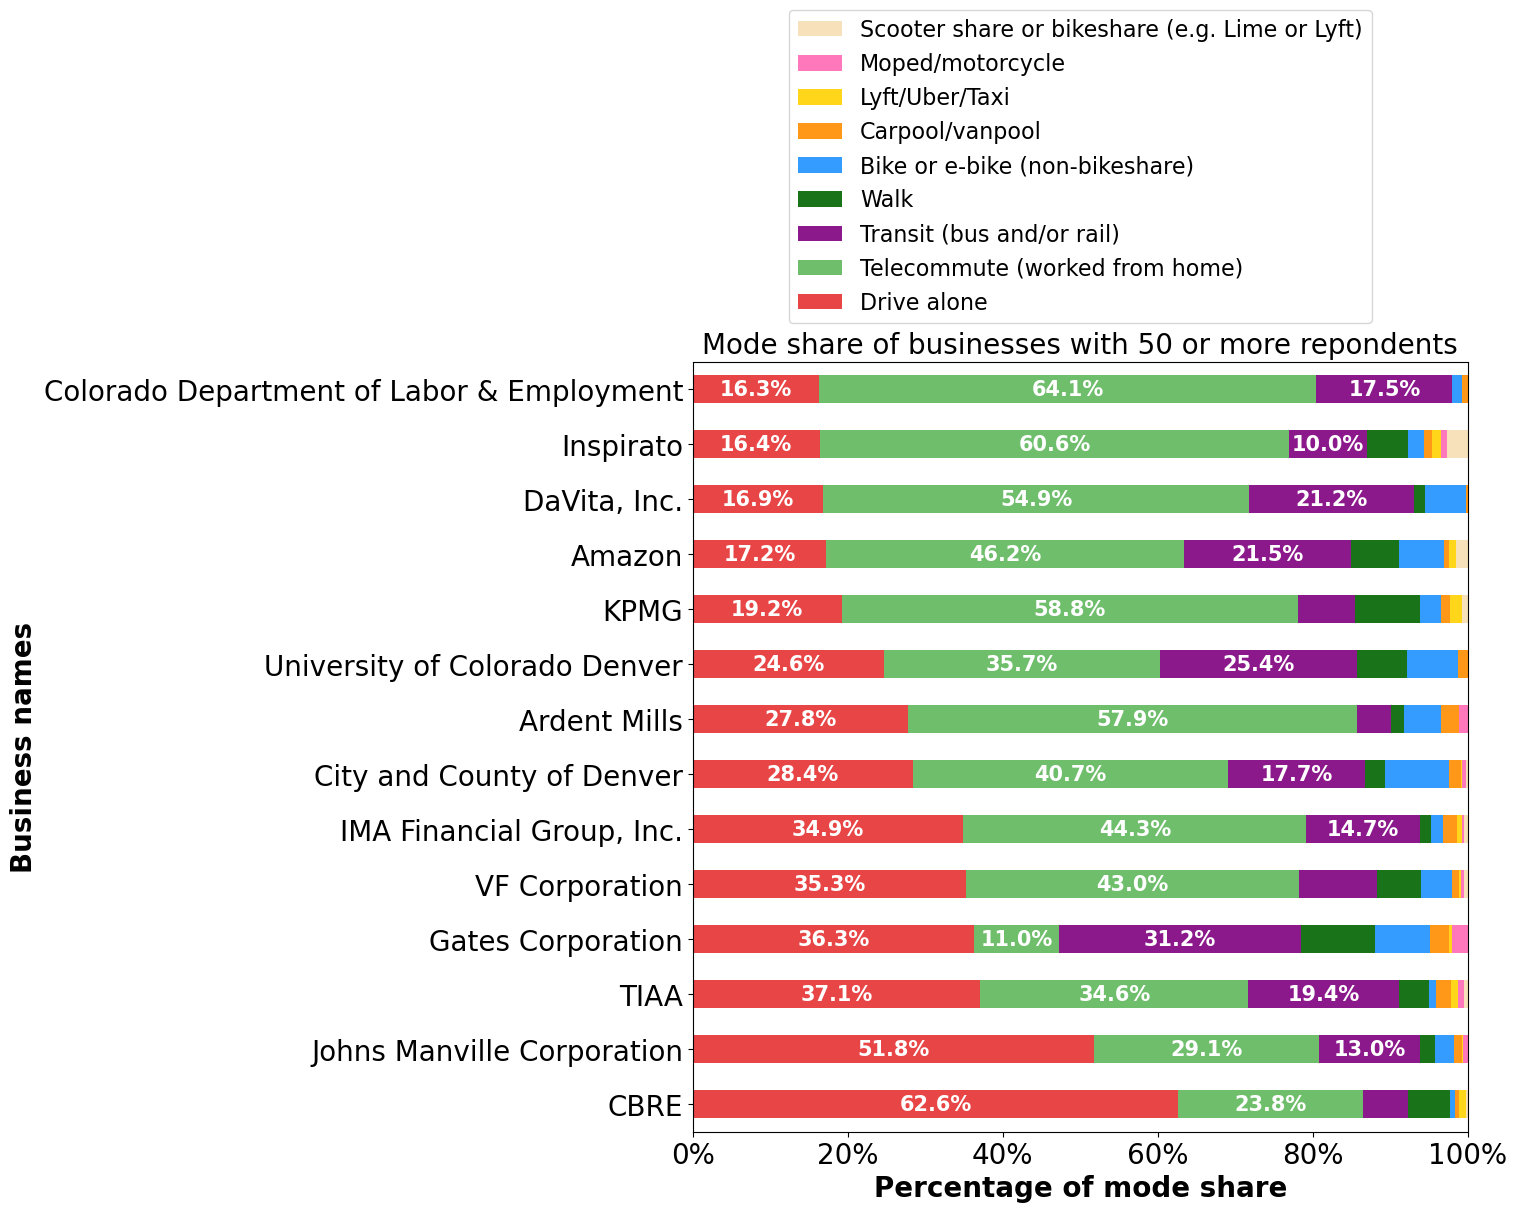

In [4]:
import matplotlib.ticker as mtick

def sum_columns(df):
    # Create an empty dictionary to store column names and their corresponding sum
    col_sum_dict = {}
    
    # removed cols
    rm_cols = []

    # Loop through each column in the dataframe
    for col in df.columns:
        if col not in rm_cols:
            # Split the column name using the delimiter "_"
            col_parts = col.split("_")
            # Check if the last part of the column name is the same as any other column names
            matching_cols = [c for c in df.columns if c.endswith(col_parts[-1]) and c != col]
            if matching_cols:

                # If there are matching columns, sum the values in all columns and store the result in the dictionary
                col_sum = df[[col] + matching_cols].sum(axis=1)
                
                # Store the sum under a new column name
                col_sum_dict[col_parts[-1]] = col_sum

                # ad to removed columns
                rm_cols = rm_cols + [col] + matching_cols
            else:
                # If there are no matching columns, simply store the column in the dictionary with its original name and values
                col_sum_dict[col] = df[col]

    # Return a new dataframe with the columns and their corresponding sum
    return pd.DataFrame(col_sum_dict)

# group by on a given column name
def group_and_count(df, group_column_name, count_columns):
    grouped = df.groupby(group_column_name)
    result = grouped.size().reset_index(name='counts')
    
    for col in count_columns:
        count_by_group = grouped[col].value_counts().unstack(fill_value=0)
        count_by_group = count_by_group.add_prefix(col+'_').reset_index()
        result = result.merge(count_by_group, on=group_column_name)
    
    result = result.sort_values('counts', ascending=False)
    
    return result


import matplotlib.colors as mcolors

def plot_stacked_histogram(df):
    # Select only the numeric columns for the normalization and plotting
    df_numeric = df.select_dtypes(include="number")
    
    if 'counts' in df_numeric.columns:
        df_numeric = df_numeric.drop(axis=1, columns='counts')
    
    # Normalize the data so that each row adds up to 1
    df_norm = df_numeric.div(df_numeric.sum(axis=1), axis=0)
    
    # Sort the columns based on the sum of their values
#     df_norm = df_norm[df_norm.sum().sort_values(ascending=False).index]
    
    # Multiply the data by 100 to convert to percentages
    df_norm *= 100
    
    color_dict = {
        'Drive alone': '#e63132',
        'Telecommute (worked from home)': '#5fb75c',
        'Transit (bus and/or rail)': '#800080',
        'Bike or e-bike (non-bikeshare)': '#1e90ff',
        'Walk': '#006400',
        'Carpool/vanpool': '#ff8c00',
        'Lyft/Uber/Taxi': '#ffd200',
        'Moped/motorcycle': '#ff69b4',
        'Scooter share or bikeshare (e.g. Lime or Lyft)': '#f5deb3'
    }
    

    # Create a ListedColormap object from the specified colors
    print(df_norm.columns)
    colors = [color_dict[col] for col in df_norm.columns]
    cmap = mcolors.ListedColormap(colors)
    
    # Plot the normalized data as a stacked horizontal bar chart
    plot = df_norm.plot(kind='barh', 
                        stacked=True, 
#                         colormap='Set1', 
                        colormap=cmap,
                        alpha=0.9,
                        figsize=(10, 10))
    
    # Access the legend and modify its properties
    plot.legend(bbox_to_anchor=(0.5, 1.05), loc='lower center', borderaxespad=0., fontsize=16, ncol=1)
    handles, labels = plot.get_legend_handles_labels()
    plot.legend(handles[::-1], labels[::-1], bbox_to_anchor=(0.5, 1.05), loc='lower center', borderaxespad=0., fontsize=16, ncol=1)

    
    # Set the x-axis tick format to show percentages
    plot.xaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add text labels with the percentages for each bar
    for i, v in enumerate(df_norm.values):
        total = sum(v)
        cumsum = 0
        for j, x in enumerate(v):
            if x >= 10:
                xpos = cumsum + x / 2
                label = f'{x:.1f}%'
                plot.text(xpos, i, label, ha='center', va='center', color='white', fontsize=15, fontweight='heavy')
            cumsum += x
    
    plt.xlabel("Percentage of mode share", fontsize=20, fontweight='bold')
    plt.title("Mode share of businesses with 50 or more repondents", fontsize=20)
    plt.ylabel("Business names", fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plot.set_xlim([0, 100])
    
    # Export the plot as a PNG file
    plt.savefig('modal_share_by_business.png', bbox_inches='tight', dpi=600)
    
    # Display the plot with the legend outside the figure
    plt.show()

# group data by business name
group_by_col = ['business name']


business_gp = group_and_count(df, group_by_col, ['Monday mode',
                       'Tuesday mode', 
                       'Wednesday mode',
                       'Thursday mode', 
                       'Friday mode'])

# number of selected modes for each business
modes_business_gp = sum_columns(business_gp).set_index(group_by_col)
filt = modes_business_gp['counts'] >= 50
modes_lg_business_gp = modes_business_gp[filt]

df_numeric = modes_lg_business_gp.select_dtypes(include="number")

if 'counts' in df_numeric.columns:
    df_numeric = df_numeric.drop(axis=1, columns='counts')

# Normalize the data so that each row adds up to 1
df_norm = df_numeric.div(df_numeric.sum(axis=1), axis=0)

plt_data = modes_lg_business_gp.drop(columns=['Did not work'])
plt_data = plt_data[plt_data.index != 'Other']
df_numeric = plt_data.select_dtypes(include="number")
if 'counts' in df_numeric.columns:
    df_numeric = df_numeric.drop(axis=1, columns='counts')
df_norm = df_numeric.div(df_numeric.sum(axis=1), axis=0)
df_sorted = df_norm[df_norm['Drive alone'] > 0].sort_values('Drive alone', ascending=False)
plt_data_sorted = pd.concat([df_sorted, plt_data['counts']], axis=1, sort=False)

first_columns = ['Drive alone', 'Telecommute (worked from home)', 'Transit (bus and/or rail)', 'Walk']
sorted_columns = first_columns + [col for col in list(plt_data.columns) if col not in first_columns]
plt_data = plt_data.loc[list(plt_data_sorted.index),sorted_columns]
plot_stacked_histogram(plt_data)

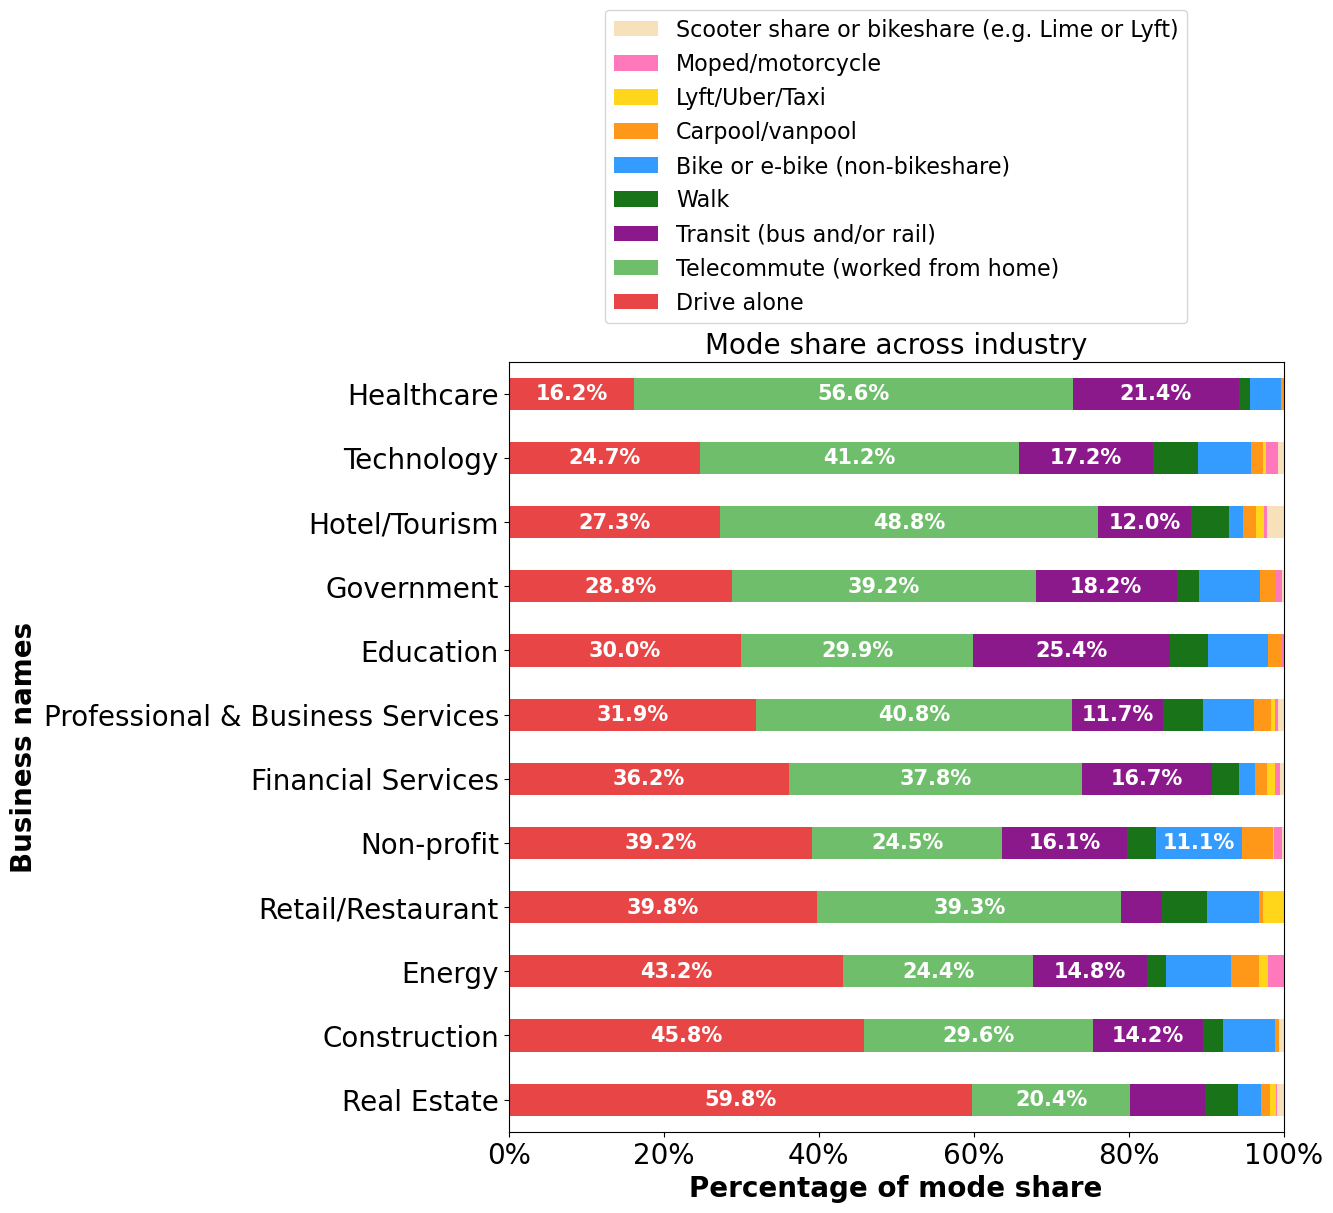

In [48]:
import matplotlib.ticker as mtick

def sum_columns(df):
    # Create an empty dictionary to store column names and their corresponding sum
    col_sum_dict = {}
    
    # removed cols
    rm_cols = []

    # Loop through each column in the dataframe
    for col in df.columns:
        if col not in rm_cols:
            # Split the column name using the delimiter "_"
            col_parts = col.split("_")
            # Check if the last part of the column name is the same as any other column names
            matching_cols = [c for c in df.columns if c.endswith(col_parts[-1]) and c != col]
            if matching_cols:

                # If there are matching columns, sum the values in all columns and store the result in the dictionary
                col_sum = df[[col] + matching_cols].sum(axis=1)
                
                # Store the sum under a new column name
                col_sum_dict[col_parts[-1]] = col_sum

                # ad to removed columns
                rm_cols = rm_cols + [col] + matching_cols
            else:
                # If there are no matching columns, simply store the column in the dictionary with its original name and values
                col_sum_dict[col] = df[col]

    # Return a new dataframe with the columns and their corresponding sum
    return pd.DataFrame(col_sum_dict)

# group by on a given column name
def group_and_count(df, group_column_name, count_columns):
    grouped = df.groupby(group_column_name)
    result = grouped.size().reset_index(name='counts')
    
    for col in count_columns:
        count_by_group = grouped[col].value_counts().unstack(fill_value=0)
        count_by_group = count_by_group.add_prefix(col+'_').reset_index()
        result = result.merge(count_by_group, on=group_column_name)
    
    result = result.sort_values('counts', ascending=False)
    
    return result


import matplotlib.colors as mcolors

def plot_stacked_histogram(df):
    # Select only the numeric columns for the normalization and plotting
    df_numeric = df.select_dtypes(include="number")
    
    if 'counts' in df_numeric.columns:
        df_numeric = df_numeric.drop(axis=1, columns='counts')
    
    # Normalize the data so that each row adds up to 1
    df_norm = df_numeric.div(df_numeric.sum(axis=1), axis=0)
    
    # Sort the columns based on the sum of their values
#     df_norm = df_norm[df_norm.sum().sort_values(ascending=False).index]
    
    # Multiply the data by 100 to convert to percentages
    df_norm *= 100
    
    color_dict = {
        'Drive alone': '#e63132',
        'Telecommute (worked from home)': '#5fb75c',
        'Transit (bus and/or rail)': '#800080',
        'Bike or e-bike (non-bikeshare)': '#1e90ff',
        'Walk': '#006400',
        'Carpool/vanpool': '#ff8c00',
        'Lyft/Uber/Taxi': '#ffd200',
        'Moped/motorcycle': '#ff69b4',
        'Scooter share or bikeshare (e.g. Lime or Lyft)': '#f5deb3'
    }
    

    # Create a ListedColormap object from the specified colors
    df_norm.to_excel('df_norm.xlsx')
    colors = [color_dict[col] for col in df_norm.columns]
    cmap = mcolors.ListedColormap(colors)
    
    # Plot the normalized data as a stacked horizontal bar chart
    plot = df_norm.plot(kind='barh', 
                        stacked=True, 
#                         colormap='Set1', 
                        colormap=cmap,
                        alpha=0.9,
                        figsize=(10, 10))
    
    # Access the legend and modify its properties
    plot.legend(bbox_to_anchor=(0.5, 1.05), loc='lower center', borderaxespad=0., fontsize=16, ncol=1)
    handles, labels = plot.get_legend_handles_labels()
    plot.legend(handles[::-1], labels[::-1], bbox_to_anchor=(0.5, 1.05), loc='lower center', borderaxespad=0., fontsize=16, ncol=1)

    
    # Set the x-axis tick format to show percentages
    plot.xaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add text labels with the percentages for each bar
    for i, v in enumerate(df_norm.values):
        total = sum(v)
        cumsum = 0
        for j, x in enumerate(v):
            if x >= 10:
                xpos = cumsum + x / 2
                label = f'{x:.1f}%'
                plot.text(xpos, i, label, ha='center', va='center', color='white', fontsize=15, fontweight='heavy')
            cumsum += x
    
    plt.xlabel("Percentage of mode share", fontsize=20, fontweight='bold')
    plt.title("Mode share across industry", fontsize=20)
    plt.ylabel("Business names", fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plot.set_xlim([0, 100])
    
    # Export the plot as a PNG file
    plt.savefig('modal_share_by_business.png', bbox_inches='tight', dpi=600)
    
    # Display the plot with the legend outside the figure
    plt.show()

# group data by business name
group_by_col = ['industry']


business_gp = group_and_count(df, group_by_col, ['Monday mode',
                       'Tuesday mode', 
                       'Wednesday mode',
                       'Thursday mode', 
                       'Friday mode'])

# number of selected modes for each business
modes_business_gp = sum_columns(business_gp).set_index(group_by_col)
filt = modes_business_gp['counts'] >= 0
modes_lg_business_gp = modes_business_gp[filt]

df_numeric = modes_lg_business_gp.select_dtypes(include="number")

if 'counts' in df_numeric.columns:
    df_numeric = df_numeric.drop(axis=1, columns='counts')

# Normalize the data so that each row adds up to 1
df_norm = df_numeric.div(df_numeric.sum(axis=1), axis=0)

plt_data = modes_lg_business_gp.drop(columns=['Did not work'])
plt_data = plt_data[plt_data.index != 'Other']
df_numeric = plt_data.select_dtypes(include="number")
if 'counts' in df_numeric.columns:
    df_numeric = df_numeric.drop(axis=1, columns='counts')
df_norm = df_numeric.div(df_numeric.sum(axis=1), axis=0)
df_sorted = df_norm[df_norm['Drive alone'] > 0].sort_values('Drive alone', ascending=False)
plt_data_sorted = pd.concat([df_sorted, plt_data['counts']], axis=1, sort=False)

first_columns = ['Drive alone', 'Telecommute (worked from home)', 'Transit (bus and/or rail)', 'Walk']
sorted_columns = first_columns + [col for col in list(plt_data.columns) if col not in first_columns]
plt_data = plt_data.loc[list(plt_data_sorted.index),sorted_columns]
plot_stacked_histogram(plt_data)

In [48]:
# process employer provided transportation programs
def add_new_columns(df, column_name):
    
    df_new = df.copy()
    # Split the string in the specified column by comma delimiter and convert to a set
    all_values = set(",".join(df_new[column_name]).split(","))
    
    # Loop through the set of all unique values and add a new column to the DataFrame for each
    for new_col in all_values:
        # Check if the value is already a column in the DataFrame
        if new_col not in df_new.columns:
            if new_col not in ["Other", "NA"]:
                # If it's not already a column, add it and fill with 'Yes' if it appears in the original column
                df_new[new_col] = df_new[column_name].apply(lambda x: 1 if new_col in x.split(",") else 0)
    
    return df_new

df = add_new_columns(df, 'employer provided transportation programs') 
df.drop('employer provided transportation programs', axis= 1, inplace=True)

In [49]:
def modal(percentage):
    modal = "NA"
    if percentage < 0.2:
        modal = 0
    elif percentage >= 0.2 and percentage < 0.4 :
        modal = 1
    elif percentage >= 0.4 and percentage < 0.6 :
        modal = 2
    elif percentage >= 0.6 and percentage < 0.8 :
        modal = 3
    elif percentage >= 0.8 and percentage < 1 :
        modal = 4
    elif percentage == 1 :
        modal = 5
    return modal

def add_frequency_of_modes(df, mode_type, columns_to_search): 

    # Initialize a list to store the counts
    modal_frequency = []

    # Loop through each row of the DataFrame and count the matches
    for index, row in df.iterrows():
        match_count = 0
        for col_name in columns_to_search:
            if row[col_name] == mode_type:
                match_count += 1
        modal_frequency.append(modal(match_count/len(columns_to_search)))

    # Add the match counts to the DataFrame as a new column
    df[f"frequency of {mode_type}"] = modal_frequency
    
    return df

# Concatenate the columns and apply the unique() method
columns_to_search = ["Monday mode", "Tuesday mode", "Wednesday mode", "Thursday mode", "Friday mode"]
mode_types = []
for col in columns_to_search:
    [mode_types.append(x) for x in list(df[col].unique()) if x not in mode_types]

for mode_type in mode_types:
    df = add_frequency_of_modes(df, mode_type, columns_to_search)

In [50]:
def onehot_encode_columns(df, columns):
    
    df_new = df.copy()

    # Create a new DataFrame to hold the encoded columns
    encoded_df = pd.DataFrame()

    # Create a list to hold the new column names
    new_cols = []

    # Iterate over each column to encode
    for col in columns:
        # Perform one-hot encoding for the column
        encoded_col = pd.get_dummies(df_new[col], prefix=col)

        # Append the encoded column(s) to the new DataFrame
        encoded_df = pd.concat([encoded_df, encoded_col], axis=1)

        # Add the new column names to the list
        new_cols.extend(encoded_col.columns)

    # Merge the encoded columns back into the original DataFrame
    df_new = pd.concat([df_new, encoded_df], axis=1)

    # Drop the original columns from the DataFrame
    df_new = df_new.drop(columns=columns)

    return df_new

### Remove some columns that we do not need

In [51]:
df.drop(['home address', 
         'home zip code', 
         'work address',
         'work zip code', 
         'Monday mode', 
         'Tuesday mode', 
         'Wednesday mode',
         'Thursday mode', 
         'Friday mode', 
         'Saturday mode', 
         'Sunday mode',
         'arrival time at work', 
         'departure time from work', 
         'departure_time_outgoing', 
         'departure_time_return'], axis=1, inplace=True)


### make two columns for gender

In [52]:
df['gender'].replace(0,"Female", inplace=True)
df['gender'].replace(1,"Male", inplace=True)
df = onehot_encode_columns(df, ['gender'])

### Save Post Processed Data
at this point the data should be clear and should not include nan

# Correlation

In [53]:
from scipy.stats import spearmanr

def plot_correlation(df, target_col, fig_title):
    # calculate the correlation coefficients and p-values
    correlations, p_values = [], []
    for col in df.columns.drop(target_col):
        correlation, p_value = stats.pearsonr(df[col], df[target_col])
        correlations.append(correlation)
        p_values.append(p_value)

    # create a series for the correlations and p-values
    correlations = pd.Series(correlations, index=df.columns.drop(target_col))
    p_values = pd.Series(p_values, index=df.columns.drop(target_col))

    # sort the correlations and p_values in descending order
    sorted_correlations = correlations.sort_values(ascending=False)
    sorted_p_values = p_values.loc[sorted_correlations.index]
    
    # set the color palette for positive and negative correlations
    color_palette = {'pos': '#21abcd', 'neg': '#ff8c00'}

    # create a seaborn barplot with colormaps, sorted in descending order
    sns.set(style='whitegrid')
    plt.figure(figsize=(8, 6))
#     ax = sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='icefire')
    ax = sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette=[color_palette['pos'] if x > 0 else color_palette['neg'] for x in sorted_correlations.values])

    # insignificant features
    insignificant_features = []
    
    # add p-values to the barplot
    for i, v in enumerate(sorted_p_values):
        # set x position based on correlation sign
        x_pos = sorted_correlations[i] + 0.01 if sorted_correlations[i] > 0 else sorted_correlations[i] - 0.4
        if v <= 0.05:
            ax.text(x_pos, i, f'p value <= 5%', color='green', fontsize=14, va='center')
        else:
            ax.text(x_pos, i, f'p value={v*100:.1f}%', color='red', fontsize=14, va='center')
            insignificant_features.append(sorted_correlations.index[i])

    plt.title(fig_title,fontsize=16)
    plt.xlabel('Correlation',fontsize=16)
    plt.ylabel('Features',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Set the x-axis limits
    ax.set(xlim=(-1, 1))

    # Export the plot as a PNG file
    plt.savefig(f'Correlation_{fig_title}.png', bbox_inches='tight', dpi=600)
    plt.show()

    return insignificant_features, sorted_correlations, sorted_p_values


## Bike

### Spearman Correlation

The magnitude of a Spearman correlation coefficient indicates the strength of the relationship between two variables, just like with a Pearson correlation coefficient. However, the Spearman correlation coefficient measures the strength and direction of the monotonic relationship between two variables, rather than the linear relationship.

A monotonic relationship is a relationship between two variables where one variable tends to increase or decrease as the other variable increases or decreases, but not necessarily at a constant rate. In other words, a monotonic relationship is a relationship where the variables move together, but not necessarily in a straight line.

The magnitude of the Spearman correlation coefficient tells us how strong the monotonic relationship is between the two variables. A coefficient closer to -1 or 1 indicates a stronger monotonic relationship, while a coefficient closer to 0 indicates a weaker relationship. However, it's important to note that a large Spearman correlation coefficient does not necessarily imply causation or a direct relationship between the variables, and other factors may be involved.


a value of +1 indicates a perfect positive monotonic relationship, where the variables increase or decrease together at a constant rate.
a value of -1 indicates a perfect negative monotonic relationship, where one variable increases as the other variable decreases at a constant rate.
a value of 0 indicates no monotonic relationship between the variables.
The interpretation of the strength of the correlation coefficient can vary, but a common rule of thumb is:

0.00-0.19: very weak correlation <br>
0.20-0.39: weak correlation <br>
0.40-0.59: moderate correlation <br>
0.60-0.79: strong correlation <br>
0.80-1.0: very strong correlation <br>

It's important to note that these ranges are not set in stone, and the interpretation of the strength of the correlation can depend on the specific context and the variables being studied. Additionally, the interpretation of the correlation should always be accompanied by a visual inspection of the data to ensure that the relationship is not being driven by outliers or other data artifacts.

In [54]:
from imblearn.over_sampling import RandomOverSampler
def over_sampling(df, target):
    # Separate the dataset into features and target columns
    X = df.drop(target, axis=1)
    y = df[target]

    # Perform oversampling to balance the dataset
    oversample = RandomOverSampler()
    X_resampled, y_resampled = oversample.fit_resample(X, y)

    # Compute the correlation between features and target
    df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
    
    return df_resampled

In [55]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

def minmax_scale_columns(df, columns_to_scale):
    # Copy the input DataFrame to avoid modifying it
    scaled_df = df.copy()

    # Initialize a scaler object
    scaler = StandardScaler()

    # Scale each specified column
    for col in columns_to_scale:
        scaled_values = scaler.fit_transform(scaled_df[[col]])
        scaled_df[col] = scaled_values.flatten()

    return scaled_df


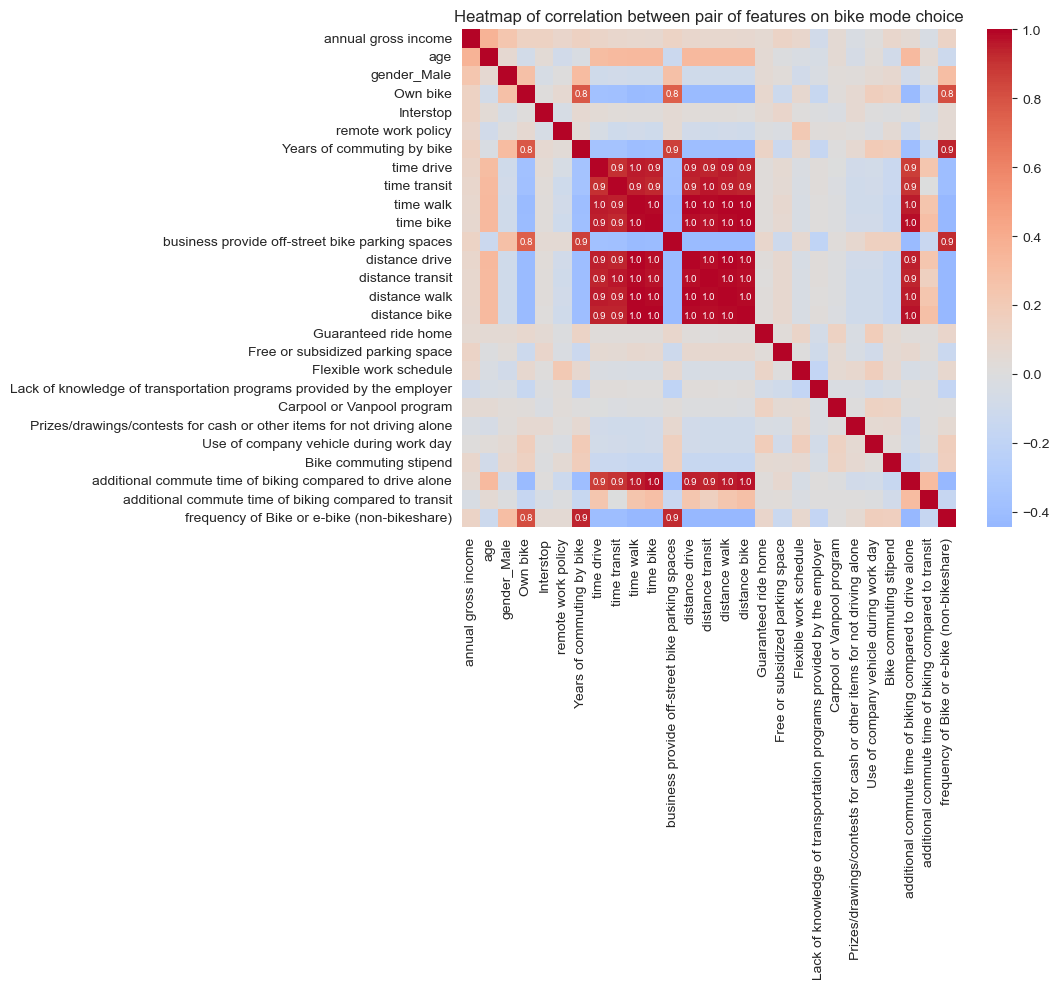

In [56]:
bike_related_cols = ['annual gross income', 'age', 'gender_Male','Own bike',
       'Interstop','remote work policy','Years of commuting by bike',
       'time drive', 'time transit', 'time walk', 'time bike',
       'business provide off-street bike parking spaces',
       'distance drive', 'distance transit', 'distance walk', 'distance bike',
       'Guaranteed ride home', 'Free or subsidized parking space',
       'Flexible work schedule',
       'Lack of knowledge of transportation programs provided by the employer',
       'Carpool or Vanpool program', 
       'Prizes/drawings/contests for cash or other items for not driving alone',
       'Use of company vehicle during work day', 'Bike commuting stipend',
       'frequency of Bike or e-bike (non-bikeshare)']

# create dataframe related to analyzing bike frequency
df_bike = df[bike_related_cols].copy()

# include additiona commute times
df_bike['additional commute time of biking compared to drive alone'] = df.loc[:, 'time bike'] - df.loc[:, 'time drive']
df_bike['additional commute time of biking compared to transit'] = df.loc[:, 'time bike'] - df.loc[:, 'time transit']

# check if you would like to change frequency to boolean
change_frequency_to_boolean = True
if change_frequency_to_boolean:
    df_bike = df_bike.loc[:, df_bike.columns]
    df_bike.loc[df_bike['frequency of Bike or e-bike (non-bikeshare)'] > 0, 'frequency of Bike or e-bike (non-bikeshare)'] = 1

# perform over sampleing to cure imbalance in data
target = 'frequency of Bike or e-bike (non-bikeshare)'
df_bike_resampled = over_sampling(df_bike, target)

# scale data
columns_to_scale = ['additional commute time of biking compared to drive alone', 'additional commute time of biking compared to transit']
df_bike_resampled_scaled = minmax_scale_columns(df_bike_resampled,columns_to_scale)

corr_matrix = df_bike_resampled_scaled.corr(method='spearman')
mask = ((corr_matrix >= 0.7) | (corr_matrix <= -0.7)) & ((corr_matrix != 1.0) & (corr_matrix != -1.0) )
sns.set_style('white')
plt.figure(figsize=(11, 10))
annot_values = np.where(mask, np.round(corr_matrix, 1).astype(str), '')
sns.heatmap(corr_matrix, annot=annot_values, fmt='', cmap='coolwarm', annot_kws={"fontsize": 7, "color": "white"}, center=0, cbar=True)

# Customize the x and y tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Heatmap of correlation between pair of features on bike mode choice')

plt.savefig('Correlation of features for frequency of biking.png', bbox_inches='tight', dpi=800)



# Adjust the figure layout
plt.tight_layout()
plt.show()


### Notes:
* "Years of Commuting by Bike" is dropped. The reason is that any commuter reported the use of bike, were asked to answer this question. Therefore this feature becomes trivial for ML models on using bike.
* "Business provide off-street bike parking spaces" is dropped. The reason is that any commuter who reported that they DO NOT use bike, were not required to answer this question. Therefore, this feature becomes trivial for ML models on using bike.
* "Own bike" is dropped. The reason is that only 11 commuters (<0.4% of respondents) specified they do not own a bike, but bike to work, and nealry 97% of commuters who bike, own a bike. These two are highly correlated.
* "E-scooter membership or credits" is dropped. The reason is that only 8 respondents reported they are provided with E-scooter membership or credits, and there is not much data to validate the analysis.
* "Private employer shuttle". is dropped. The reason is that only 1 respondent reported that.


You could check the heatmap of correlations between bike related features and if the commute uses bike to commute to work. These three features are shown to be highly correlated, and they do not make sense to be included in ML models, as they cause overfitting.

transportation programs number of respondents  \
0                         Free transit pass (EcoPass)                  1505   
1                                 Secure bike parking                  1431   
2                              Flexible work schedule                  1364   
3                    Free or subsidized parking space                   859   
4           Subsidized transit fair or pass (EcoPass)                   847   
5     business provide off-street bike parking spaces                   326   
6   Lack of knowledge of transportation programs p...                   263   
18                    Flexible transportation benefit                   252   
7              Use of company vehicle during work day                   187   
8                                Guaranteed ride home                   185   
9         Compressed work week (4 work days per week)                   170   
10   Bike routes/maps and safety information/seminars                   101   
11                             Bike commuting stipend                    61   
12                         Carpool or Vanpool program                    33   
13                     Carshare membership or credits                    20   
14                      Preferred parking for carpool                    16   
15  Prizes/drawings/contests for cash or other ite...                    15   
16                    E-scooter membership or credits                     8   
17                           Private employer shuttle                     1   

    percentage (%)  
0        48.037025  
1        45.675072  
2        43.536546  
3        27.417810  
4        27.034791  
5        10.405362  
6         8.394510  
18        8.043409  
7         5.968720  
8         5.904883  
9         5.426109  
10        3.223747  
11        1.947016  
12        1.053304  
13        0.638366  
14        0.510693  
15        0.478774  
16        0.255346  
17        0.031918

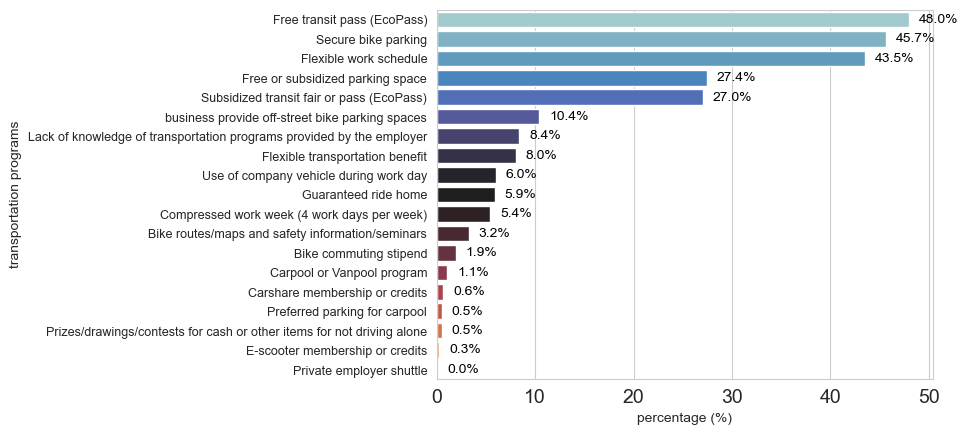

In [57]:
def count_and_percentage(df, columns):
    result = pd.DataFrame(columns=['transportation programs', 'number of respondents', 'percentage (%)'])
    
    for column in columns:
        count_1 = df[column].sum()
        percentage_1 = count_1 / len(df) * 100
        
        result = pd.concat([result, pd.DataFrame({'transportation programs': column,
                                                   'number of respondents': count_1,
                                                   'percentage (%)': percentage_1},
                                                  index=[0])],
                           ignore_index=True).sort_values(by='percentage (%)', ascending=False)
        
    sns.set_style('whitegrid')
    ax = sns.barplot(x='percentage (%)', y='transportation programs', data=result, palette='icefire')
    
    
    # adjust font size of x-axis labels
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=14)
    
    # add percentages on the right side of the bars
    for p in ax.patches:
        percentage_str = '{:.1f}%'.format(p.get_width())
        x_pos = p.get_width() + 1
        y_pos = p.get_y() + p.get_height() / 2
        ax.text(x_pos, y_pos, percentage_str, va='center', fontsize=10, color='black')
    plt.savefig('count and percentage of respondents for transportation programs.png', dpi=800, bbox_inches='tight')
    result.to_excel('transportation programs.xlsx')
    return result

columns = ['business provide off-street bike parking spaces',
       'Flexible work schedule', 'Carpool or Vanpool program',
       'Free transit pass (EcoPass)', 'Free or subsidized parking space',
       'Bike commuting stipend', 'Guaranteed ride home',
       'E-scooter membership or credits', 'Carshare membership or credits',
       'Compressed work week (4 work days per week)',
       'Subsidized transit fair or pass (EcoPass)',
       'Bike routes/maps and safety information/seminars',
       'Use of company vehicle during work day', 'Private employer shuttle',
       'Secure bike parking',
       'Lack of knowledge of transportation programs provided by the employer',
       'Preferred parking for carpool',
       'Prizes/drawings/contests for cash or other items for not driving alone',
       'Flexible transportation benefit']
transportation_programs_shares = count_and_percentage(df, columns)
transportation_programs_shares

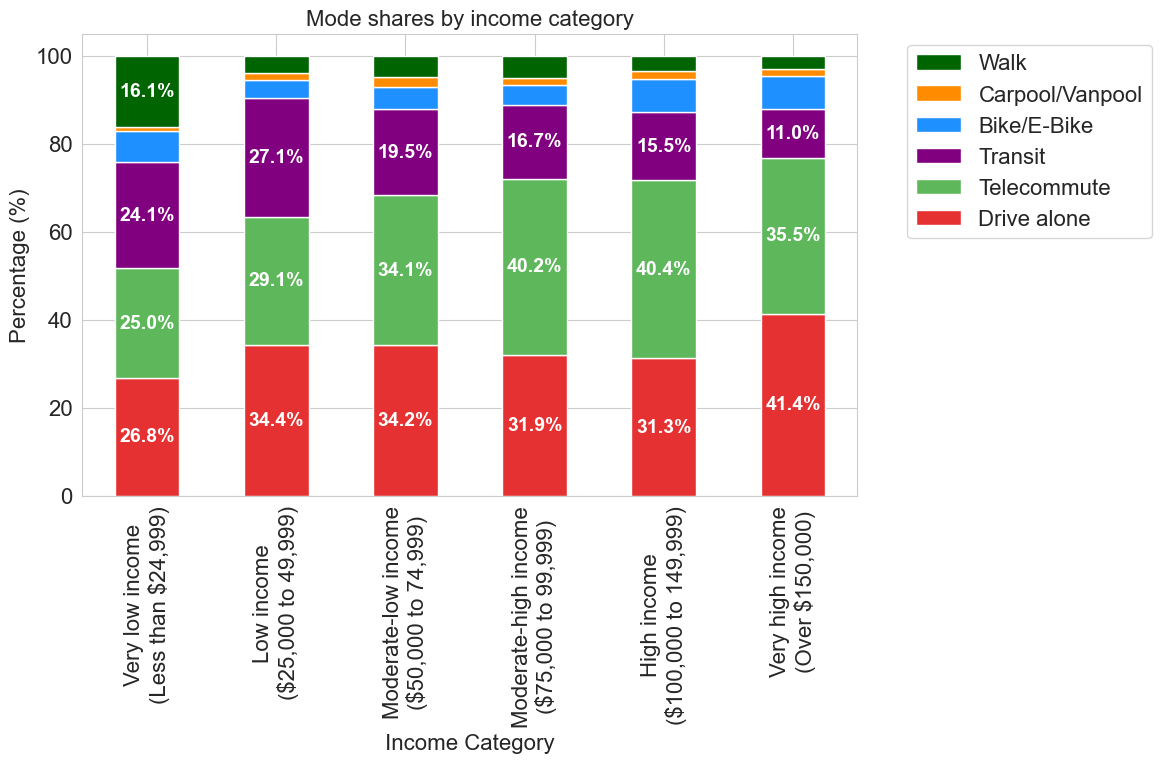

In [74]:
cols = ['annual gross income', 'frequency of Telecommute (worked from home)', 'frequency of Walk',
       'frequency of Transit (bus and/or rail)',
       'frequency of Drive alone', 'frequency of Carpool/vanpool',
       'frequency of Bike or e-bike (non-bikeshare)']



grouped_df_income = df[cols].groupby('annual gross income').sum()

grouped_df_income = grouped_df_income.reset_index()

# Create a dictionary to map income values to categories
income_categories = {
    1: 'Very low income\n(Less than $24,999)',
    2: 'Low income\n($25,000 to 49,999)',
    3: 'Moderate-low income\n($50,000 to 74,999)',
    4: 'Moderate-high income\n($75,000 to 99,999)',
    5: 'High income\n($100,000 to 149,999)',
    6: 'Very high income\n(Over $150,000)'
}

# # Map income values to categories
grouped_df_income['Income Category'] = grouped_df_income['annual gross income'].map(income_categories)
grouped_df_income.drop(columns=['annual gross income'], inplace=True)

grouped_df_income.rename(columns={'frequency of Telecommute (worked from home)': 'Telecommute',
                                 'frequency of Walk': 'Walk',
                                 'frequency of Transit (bus and/or rail)': 'Transit',
                                 'frequency of Drive alone': 'Drive alone',
                                 'frequency of Carpool/vanpool': 'Carpool/Vanpool',
                                 'frequency of Bike or e-bike (non-bikeshare)': 'Bike/E-Bike'
                                 }, inplace=True)

sorted_cols = ['Drive alone', 'Carpool/Vanpool', 'Transit', 'Bike/E-Bike', 'Walk','Telecommute', 'Income Category']
grouped_df_income = grouped_df_income[sorted_cols]

# Group the data by income category and calculate the mean of the frequency columns
grouped = grouped_df_income.groupby('Income Category').mean()

grouped = grouped[['Drive alone', 'Telecommute', 'Transit', 'Bike/E-Bike', 'Carpool/Vanpool', 'Walk']]

# Calculate the percentages of each frequency column within each income category
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100


# Define the order of the income categories
income_order = [
    'Very low income\n(Less than $24,999)',
    'Low income\n($25,000 to 49,999)',
    'Moderate-low income\n($50,000 to 74,999)',
    'Moderate-high income\n($75,000 to 99,999)',
    'High income\n($100,000 to 149,999)',
    'Very high income\n(Over $150,000)'
]

# Define your own colors for each mode of transportation
drive_color = '#e63132'
transit_color = '#800080'
telecommute_color = '#5fb75c'
bike_color = '#1e90ff'
carpool_color = '#ff8c00'
walk_color = '#006400'


# color_dict = {
#         'Drive alone': '#e63132',
#         'Telecommute (worked from home)': '#5fb75c',
#         'Used Transit (bus and/or rail)': '#800080',
#         'Bike or e-bike (non-bikeshare)': '#1e90ff',
#         'Walk': '#006400',
#         'Carpool/vanpool': '#ff8c00',
#         'Lyft/Uber/Taxi': '#ffd200',
#         'Moped/motorcycle': '#ff69b4',
#         'Scooter share or bikeshare (e.g. Lime or Lyft)': '#f5deb3'
#     }

colors = [drive_color, telecommute_color, transit_color, bike_color, carpool_color, walk_color]

# Reorder the rows based on the order of the income categories
percentages = percentages.loc[income_order]

# Define a custom color palette
# colors = sns.color_palette('rocket', n_colors=percentages.shape[1])
# colors = sns.color_palette('Set1', n_colors=percentages.shape[1])

# Create a bar chart using seaborn
ax = percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Get the handles and labels from the existing legend
handles, labels = ax.get_legend_handles_labels()

# Reverse the order of handles and labels
handles = handles[::-1]
labels = labels[::-1]

# Set the axis labels and title
ax.set_xlabel('Income Category', fontsize=16)
ax.set_ylabel('Percentage (%)', fontsize=16)
ax.set_title('Mode shares by income category', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

for i, row in enumerate(percentages.values):
    cum_sum = 0
    for j, val in enumerate(row):
        if val >= 10:
            ax.text(i, cum_sum + val/2, f'{val:.1f}%', ha='center', va='center', color='white', fontsize=14, fontweight='bold')
        cum_sum += val


# Move the legend outside the plot
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)

plt.savefig('modal share across different income groups.png', bbox_inches='tight', dpi=800)

# Show the plot
plt.show()

In [ ]:
# from scipy.stats import chi2_contingency
# # Calculate the chi-square test statistic and the corresponding p-value
# chi2, p_value, dof, expected = chi2_contingency(contingency_df)

# # Define the significance level
# alpha = 0.05

# # Interpret the results of the test
# if p_value < alpha:
#     print('There is a significant association between income category and mode choice.')
#     if expected[3, 4] > contingency_df.iloc[3, 4]:
#         print('People with higher income use driving more than people with lower income.')
#     else:
#         print('There is no evidence to support the claim that people with higher income use driving more than people with lower income.')
# else:
#     print('There is not enough evidence to support the claim that there is a significant association between income category and mode choice.')

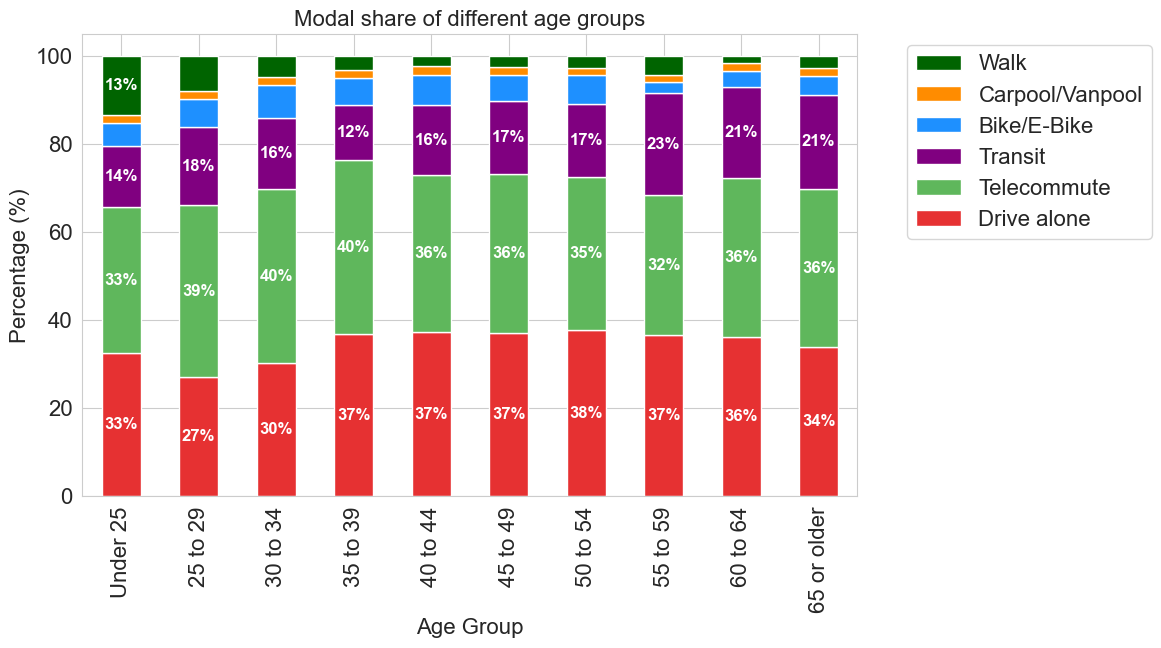

In [72]:
cols = ['age', 'frequency of Telecommute (worked from home)', 'frequency of Walk',
       'frequency of Transit (bus and/or rail)',
       'frequency of Drive alone', 'frequency of Carpool/vanpool',
       'frequency of Bike or e-bike (non-bikeshare)']



grouped_df_age = df[cols].groupby('age').sum()
grouped_df_age = grouped_df_age.reset_index()

# Create a dictionary to map income values to categories

age_groups = {0: "Under 25",
             1: "25 to 29",
             2: "30 to 34",
             3: "35 to 39",
             4: "40 to 44",
             5: "45 to 49",
             6: "50 to 54",
             7: "55 to 59",
             8: "60 to 64",
             9: "65 or older"}

# # Map income values to categories
grouped_df_age['Age Group'] = grouped_df_age['age'].map(age_groups)
grouped_df_age.drop(columns=['age'], inplace=True)

grouped_df_age.rename(columns={'frequency of Telecommute (worked from home)': 'Telecommute',
                                 'frequency of Walk': 'Walk',
                                 'frequency of Transit (bus and/or rail)': 'Transit',
                                 'frequency of Drive alone': 'Drive alone',
                                 'frequency of Carpool/vanpool': 'Carpool/Vanpool',
                                 'frequency of Bike or e-bike (non-bikeshare)': 'Bike/E-Bike'
                                 }, inplace=True)

sorted_cols = ['Drive alone', 'Carpool/Vanpool', 'Transit', 'Bike/E-Bike', 'Walk','Telecommute', 'Age Group']
grouped_df_age = grouped_df_age[sorted_cols]

grouped_df_age = grouped_df_age[['Drive alone', 'Telecommute', 'Transit', 'Bike/E-Bike', 'Carpool/Vanpool', 'Walk', 'Age Group']]

# Group the data by income category and calculate the mean of the frequency columns
grouped = grouped_df_age.groupby('Age Group').mean()

# Calculate the percentages of each frequency column within each income category
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100


# Define the order of the income categories
income_order = ["Under 25",
             "25 to 29",
             "30 to 34",
             "35 to 39",
             "40 to 44",
             "45 to 49",
             "50 to 54",
             "55 to 59",
             "60 to 64",
             "65 or older"]

# Define your own colors for each mode of transportation
drive_color = '#e63132'
transit_color = '#800080'
telecommute_color = '#5fb75c'
bike_color = '#1e90ff'
carpool_color = '#ff8c00'
walk_color = '#006400'
colors = [drive_color, telecommute_color, transit_color, bike_color, carpool_color, walk_color]

# Reorder the rows based on the order of the income categories
percentages = percentages.loc[income_order]

# Define a custom color palette
# colors = sns.color_palette('rocket', n_colors=percentages.shape[1])


# Create a bar chart using seaborn
ax = percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
# Get the handles and labels from the existing legend
handles, labels = ax.get_legend_handles_labels()

# Reverse the order of handles and labels
handles = handles[::-1]
labels = labels[::-1]


# Set the axis labels and title
ax.set_xlabel('Age Group', fontsize=16)
ax.set_ylabel('Percentage (%)', fontsize=16)
ax.set_title('Modal share of different age groups', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

for i, row in enumerate(percentages.values):
    cum_sum = 0
    for j, val in enumerate(row):
        if val >= 10:
            ax.text(i, cum_sum + val/2, f'{val:.0f}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
        cum_sum += val

        
# Move the legend outside the plot
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)

plt.savefig('modal share across different age groups.png', bbox_inches='tight', dpi=800)

# Show the plot
plt.show()

In [73]:
percentages

Drive alone  Telecommute    Transit  Bike/E-Bike  \
Age Group                                                       
Under 25       32.571429    33.142857  13.857143     5.285714   
25 to 29       27.062533    39.096164  17.866527     6.358382   
30 to 34       30.210773    39.656518  16.159251     7.416081   
35 to 39       36.807512    39.671362  12.488263     6.150235   
40 to 44       37.423625    35.590631  15.885947     6.771894   
45 to 49       37.029432    36.139630  16.632444     5.886379   
50 to 54       37.831858    34.734513  16.592920     6.526549   
55 to 59       36.593592    31.871838  23.102867     2.529511   
60 to 64       36.111111    36.222222  20.666667     3.666667   
65 or older    33.918129    35.964912  21.345029     4.385965   

             Carpool/Vanpool       Walk  
Age Group                                
Under 25            1.857143  13.285714  
25 to 29            1.786653   7.829743  
30 to 34            1.912568   4.644809  
35 to 39            1.737089   3.145540  
40 to 44            2.189409   2.138493  
45 to 49            1.779603   2.532512  
50 to 54            1.714602   2.599558  
55 to 59            1.686341   4.215852  
60 to 64            1.777778   1.555556  
65 or older         1.754386   2.631579

In [46]:
df_income = pd.DataFrame(df['annual gross income'].value_counts(normalize=True).mul(100))
df_income
income_categories = {
    1: 'Less than $24,999',
    2: '$25,000 to 49,999',
    3: '$50,000 to 74,999',
    4: '$75,000 to 99,999',
    5: '$100,000 to 149,999',
    6: 'Over $150,000',
}
df_income.index = df_income.index.map(income_categories)
df_income = df_income.sort_index()
df_income.index.name = 'Income Group'
df_income.rename(columns={'annual gross income': 'percentage of commuters (%)'})

percentage of commuters
Income Group                                
$100,000 to 149,999                24.098308
$25,000 to 49,999                   6.192148
$50,000 to 74,999                  26.907118
$75,000 to 99,999                  22.693904
Less than $24,999                   0.925630
Over $150,000                      19.182892

In [64]:
df.to_excel('raw_data.xlsx')

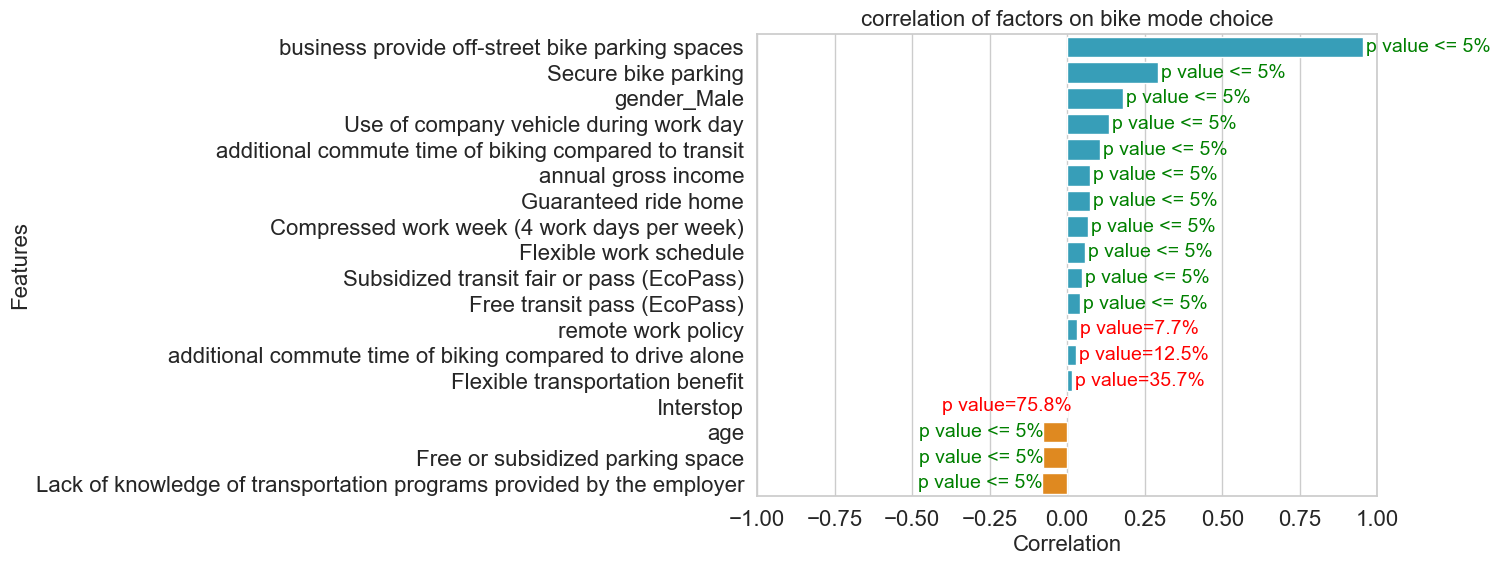

business provide off-street bike parking spaces                          0.000000e+00
Secure bike parking                                                      5.437817e-63
gender_Male                                                              3.088145e-24
Use of company vehicle during work day                                   2.955517e-14
additional commute time of biking compared to transit                    3.607031e-09
annual gross income                                                      4.440864e-05
Guaranteed ride home                                                     4.546763e-05
Compressed work week (4 work days per week)                              2.432273e-04
Flexible work schedule                                                   1.801183e-03
Subsidized transit fair or pass (EcoPass)                                7.611591e-03
Free transit pass (EcoPass)                                              2.093184e-02
remote work policy                                    

In [249]:
filt = transportation_programs_shares['percentage (%)'] >= 5
programs = list(transportation_programs_shares[filt]['transportation programs'])

bike_related_cols = programs + ['annual gross income', 'age', 'gender_Male',
       'Interstop','remote work policy',
       'frequency of Bike or e-bike (non-bikeshare)']


# create dataframe related to analyzing bike frequency
df_bike = df[bike_related_cols].copy()

# max_time_bike = 60
# # filter data based on bike time threshold
# filt = df_bike['time bike'] <= max_time_bike
# df_bike = df_bike[filt]

# include additiona commute times
df_bike['additional commute time of biking compared to drive alone'] = df.loc[:, 'time bike'] - df.loc[:, 'time drive']
df_bike['additional commute time of biking compared to transit'] = df.loc[:, 'time bike'] - df.loc[:, 'time transit']

# check if you would like to change frequency to boolean
change_frequency_to_boolean = True
if change_frequency_to_boolean:
    df_bike = df_bike.loc[:, df_bike.columns]
    df_bike.loc[df_bike['frequency of Bike or e-bike (non-bikeshare)'] > 0, 'frequency of Bike or e-bike (non-bikeshare)'] = 1

# perform over sampleing to cure imbalance in data
target = 'frequency of Bike or e-bike (non-bikeshare)'
df_bike_resampled = over_sampling(df_bike, target)

# scale data
columns_to_scale = ['additional commute time of biking compared to drive alone', 'additional commute time of biking compared to transit']
df_bike_resampled_scaled = minmax_scale_columns(df_bike_resampled,columns_to_scale)
df_bike_scaled = minmax_scale_columns(df_bike,columns_to_scale)


# plot the correlations
insignificant_features, sorted_correlations, sorted_p_values = plot_correlation(df_bike_scaled, target, 'correlation of factors on bike mode choice')
sorted_correlations
sorted_p_values

In [250]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create an Excel writer object
writer = pd.ExcelWriter('contingency_tables.xlsx')

# Create a dictionary to store the chi-square and p-value results for each column
results_dict = {}

# Select the columns for the contingency table
cols = list(df_bike_scaled.columns)

# Loop through each column
for ind, col in enumerate(cols):
    if col == 'frequency of Bike or e-bike (non-bikeshare)':
        continue
    # Create the contingency table
    cont_table = pd.crosstab(df_bike_scaled[col], df_bike_scaled['frequency of Bike or e-bike (non-bikeshare)'])
    
#     print(cont_table)
    
    # Perform the chi-square test
    chi2, pval, dof, exp = chi2_contingency(cont_table)
    
    # Add the results to the dictionary
    results_dict[col] = {'chi2': chi2, 'pval': pval}

    # Write the contingency table to a new sheet in the Excel file
    cont_table.to_excel(writer, sheet_name=str(ind))
    

# Save the Excel file
writer.save()

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results_dict, orient='index')

# Sort the DataFrame based on p-value in ascending order
results_df = results_df.sort_values(by='pval')


/var/folders/5z/csd98q8j2p7f5qdt0x6c1sh40000gn/T/ipykernel_19173/3539931137.py:33: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


### Logistic Regression Odds Ratios
Odds and probability are related but different concepts.

Probability is the measure of the likelihood of an event occurring, expressed as a value between 0 and 1, where 0 means the event is impossible and 1 means the event is certain to occur.

Odds, on the other hand, represent the ratio of the probability of an event occurring to the probability of the event not occurring. In other words, odds are the ratio of the number of favorable outcomes to the number of unfavorable outcomes. Odds can take any positive value, including 0 and infinity.

For example, if the probability of an event is 0.75, then the odds of the event are 0.75 / (1 - 0.75) = 0.75 / 0.25 = 3. Similarly, if the probability of an event is 0.25, then the odds of the event are 0.25 / (1 - 0.25) = 0.25 / 0.75 = 0.33.

In logistic regression, odds ratios are often used to interpret the effect of a predictor variable on the likelihood of the target variable.

In [251]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import exp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler

def multinomial_logistic_regression_odds_ratios(df, target, file_name, file_name_2, test_size=0.2, random_state=42):
    # Split the data into features and target
    X = df.drop(target, axis=1)  # features
    y = df[target]  # target
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Create a logistic regression model and fit it to the scaled data
    model = LogisticRegression(penalty='l2',  solver='lbfgs', max_iter=5000, random_state=random_state)
    model.fit(X_train, y_train)

    # Get the coefficients of the features and convert them to odds ratios
    coefficients = pd.Series(model.coef_[0], index=X.columns)
    odds_ratios = pd.Series(map(lambda x: np.exp(x), coefficients), index=X.columns)
    
    

    # Sort the odds ratios in descending order
    odds_ratios_sorted = odds_ratios.sort_values(ascending=False)

    # Plot the odds ratios on a horizontal bar chart
    plt.figure(figsize=(10, 7))
    # odds_ratios_sorted.drop('Years of commuting by bike', inplace=True)
    sns.barplot(x=odds_ratios_sorted.values, y=odds_ratios_sorted.index)
    plt.xscale('log')
    plt.xlabel('Odds Ratio')
    plt.ylabel('Feature')
    plt.title(f'Logistic Regression Odds Ratios - {target}')

    # Add data labels to the plot
    for i, v in enumerate(odds_ratios_sorted):
        plt.text(v, i - 0.001, str(round(v, 2)))

    plt.savefig(f'{file_name}.png', bbox_inches='tight', dpi=800)
    plt.show()
    
    ################################################
    # Plot the odds ratios on a horizontal bar chart
    plt.figure(figsize=(10, 7))
    pos_color = '#21abcd'  # blue
    neg_color = '#ff8c00'  # orange
    
    sns.barplot(x=odds_ratios_sorted.values-1, y=odds_ratios_sorted.index, 
                palette=[pos_color if v>1 else neg_color for v in odds_ratios_sorted.values])
    plt.xlabel('Change of odds ratio', fontsize=20)
    plt.ylabel('Feature', fontsize=20)
    plt.title(f'Percentage Change of Odds Ratio - {target}', fontsize=16)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    
    # Add data labels to the plot
    for i, v in enumerate(odds_ratios_sorted):
        # Calculate the percentage increase or decrease in odds
        if v > 1:
            percentage_change = f'+{round((v-1)*100)}%'
            ha = 'left'
            x_pos = v-1
        else:
            percentage_change = f'-{round((1-v)*100)}%'
            ha = 'right'
            x_pos = -(1-v)
        # Add the data label to the plot with percentage change
        plt.text(x_pos, i, f'{percentage_change}', ha=ha, va='center', fontsize=16)
        # Add a line at x=1 to indicate no change in odds
        plt.axvline(x=0, linestyle='--', color='gray')

    # Set the y-axis limit to show all the features
    plt.xlim(min(odds_ratios_sorted.values)-3, max(odds_ratios_sorted.values)+1)


    plt.savefig(f'{file_name_2}.png', bbox_inches='tight', dpi=800)

    plt.show()
    
    return odds_ratios_sorted


In [252]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import exp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler

def multinomial_logistic_regression_income_groups(df, target, test_size=0.2, random_state=42):
    # Split the data into features and target
    X = df.drop(target, axis=1)  # features
    y = df[target]  # target
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Create a logistic regression model and fit it to the scaled data
    model = LogisticRegression(penalty='l2',  solver='lbfgs', max_iter=5000, random_state=random_state)
    model.fit(X_train, y_train)

    # Get the coefficients of the features and convert them to odds ratios
    coefficients = pd.Series(model.coef_[0], index=X.columns)
    odds_ratios = pd.Series(map(lambda x: np.exp(x), coefficients), index=X.columns)

    # Sort the odds ratios in descending order
    odds_ratios_sorted = odds_ratios.sort_values(ascending=False)

    ################################################
#     # Plot the odds ratios on a horizontal bar chart
#     plt.figure(figsize=(10, 7))
#     sns.barplot(x=odds_ratios_sorted.values-1, y=odds_ratios_sorted.index)
#     plt.xlabel('Change of odds ratio')
#     plt.ylabel('Feature')
#     plt.title(f'Percentage Change of Odds Ratio - {target}')

#     # Add data labels to the plot
#     for i, v in enumerate(odds_ratios_sorted):
#         # Calculate the percentage increase or decrease in odds
#         if v > 1:
#             percentage_change = f'+{round((v-1)*100)}%'
#             ha = 'left'
#             x_pos = v-1
#         else:
#             percentage_change = f'-{round((1-v)*100)}%'
#             ha = 'right'
#             x_pos = -(1-v)
            
#         plt.text(x_pos, i, f'{percentage_change}', ha=ha, va='center', fontsize=10)
#         plt.axvline(x=0, linestyle='--', color='gray')

#     # Set the y-axis limit to show all the features
#     plt.xlim(min(odds_ratios_sorted.values)-3, max(odds_ratios_sorted.values)+1)

#     plt.show()
    
    return odds_ratios_sorted


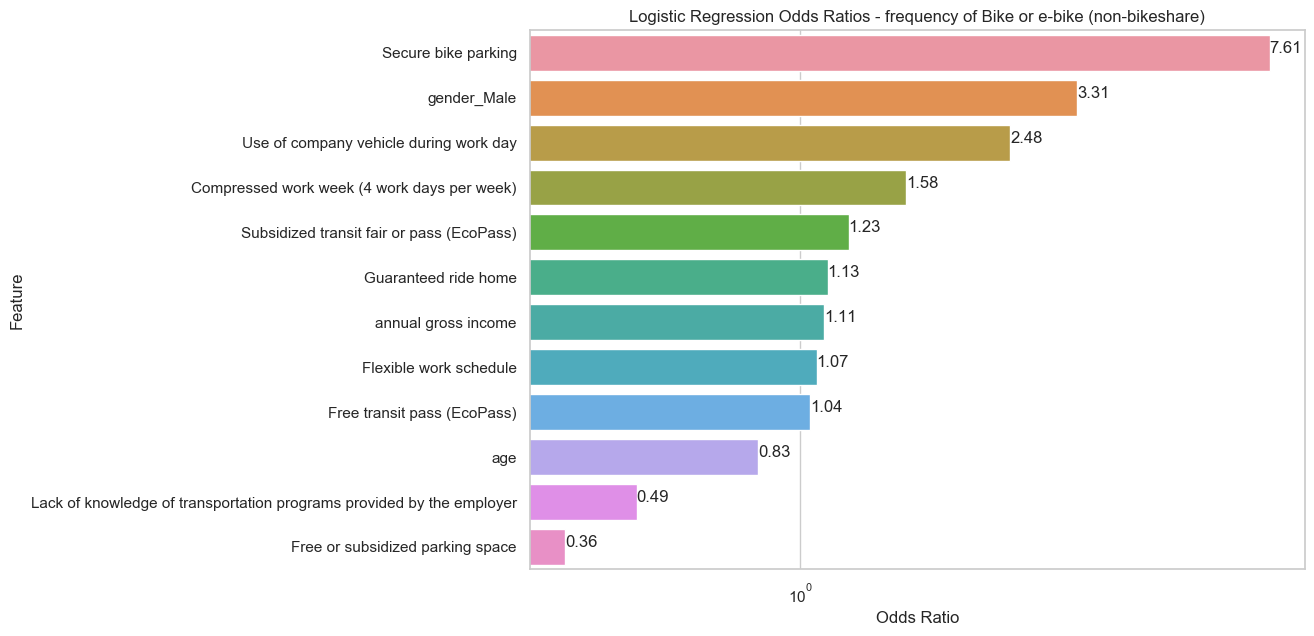

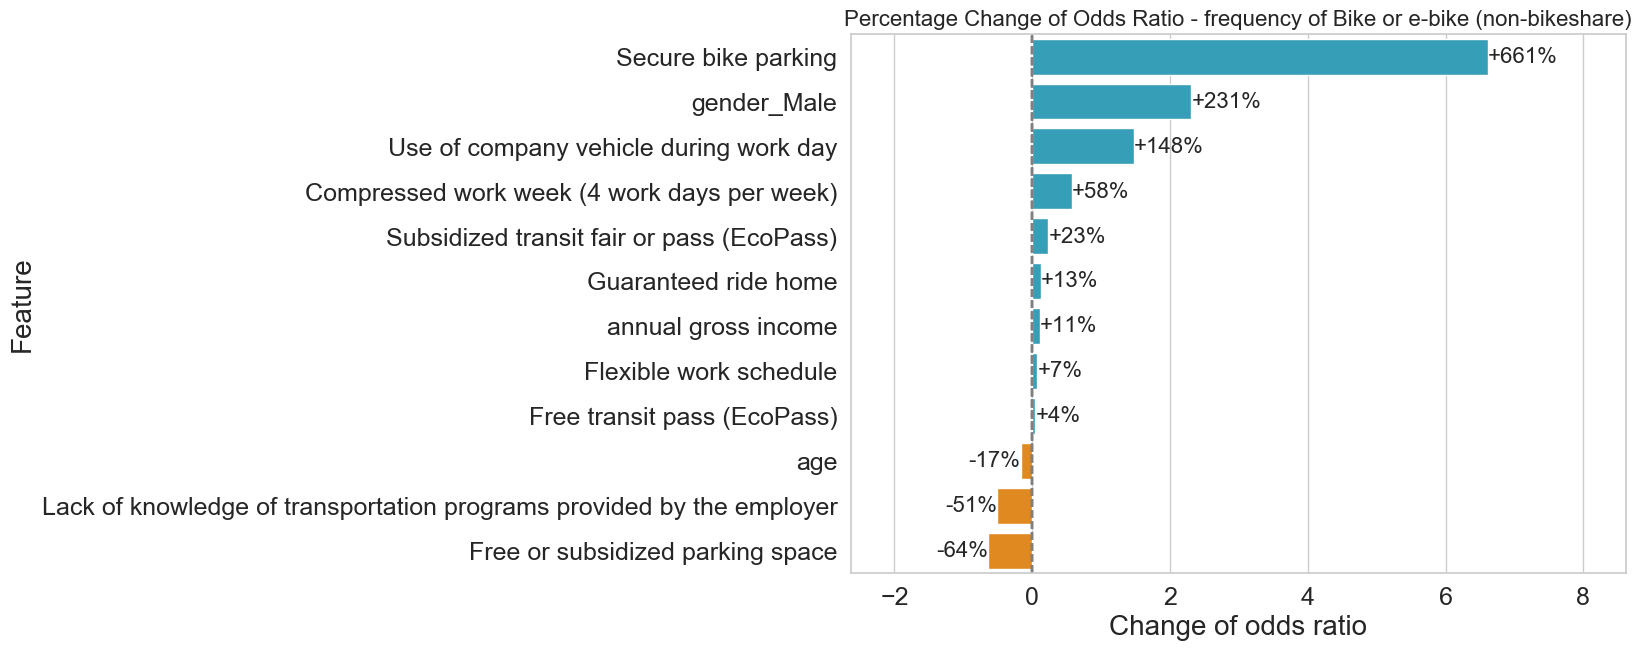

Secure bike parking                                                      661.192749
gender_Male                                                              230.844096
Use of company vehicle during work day                                   147.930772
Compressed work week (4 work days per week)                               57.922131
Subsidized transit fair or pass (EcoPass)                                 23.219561
Guaranteed ride home                                                      12.509300
annual gross income                                                       10.717229
Flexible work schedule                                                     7.271059
Free transit pass (EcoPass)                                                4.404235
age                                                                      -16.791878
Lack of knowledge of transportation programs provided by the employer    -50.782189
Free or subsidized parking space                                         -63

In [253]:
file_name = 'Logistic Regression Odds Ratios for Bike Mode'
file_name_2 = 'Percentage Change of Odds Ratios for Bike Mode'
target = 'frequency of Bike or e-bike (non-bikeshare)'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))
insignificant_features = insignificant_features + ['business provide off-street bike parking spaces']

# drop statistically insignificant features
odds_ratios_sorted = multinomial_logistic_regression_odds_ratios(df_bike_resampled_scaled.drop(columns=insignificant_features), 
                                            target, file_name, file_name_2)
(odds_ratios_sorted-1)*100

In [254]:
odds_ratio_income_dict_2

{'Income greater than $24,999': 31.429730972340298,
 'Income greater than $49,999': 52.271687263112774,
 'Income greater than $74,999': 23.914066681845835,
 'Income greater than $99,999': 39.77030495073546,
 'Income greater than $149,999': 32.464698344344576}

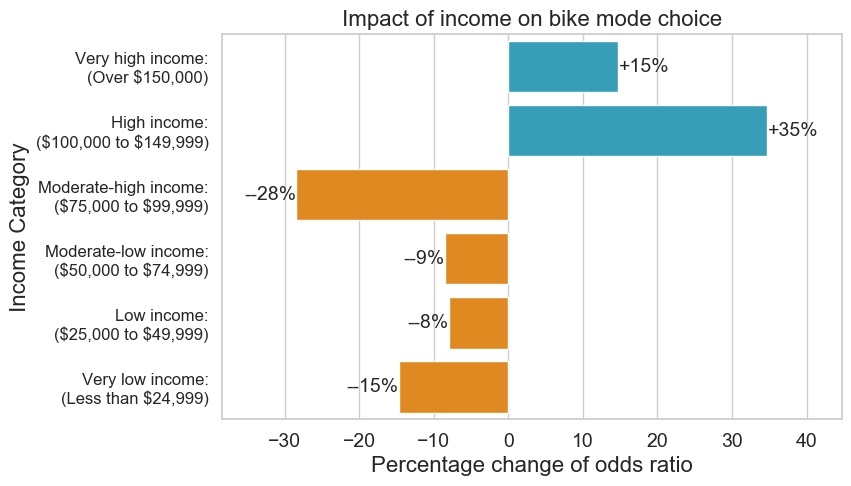

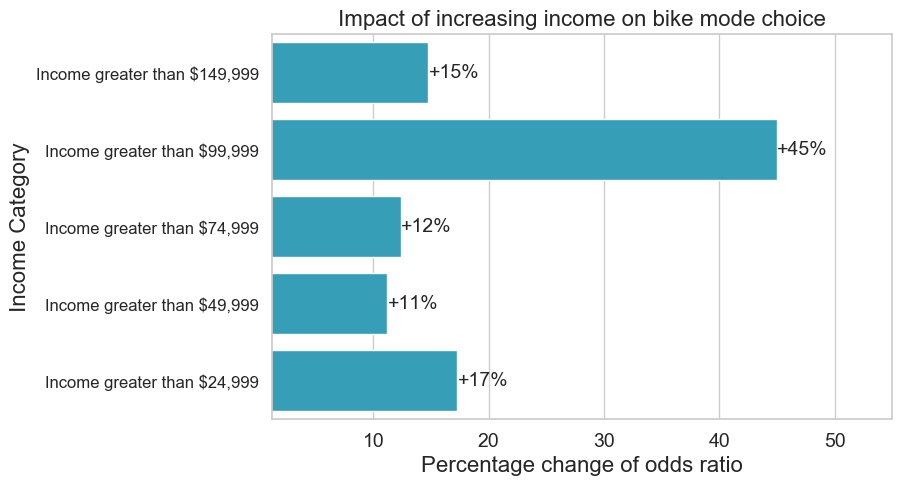

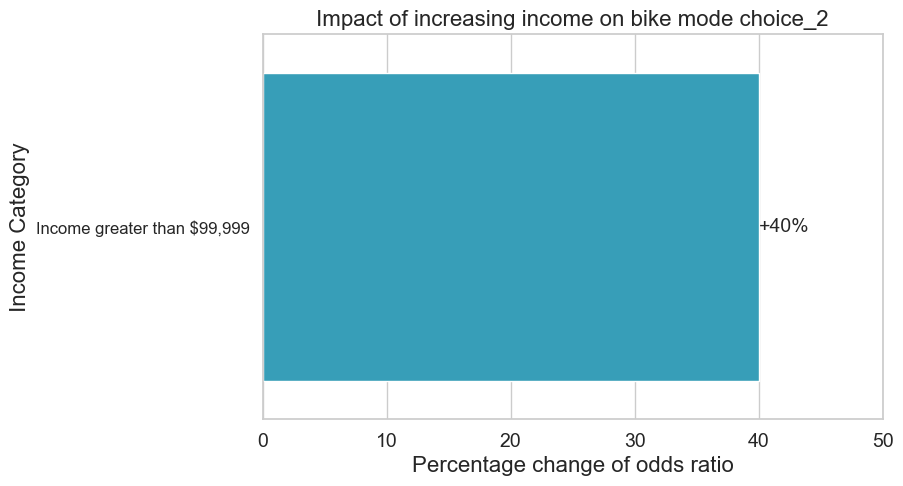

{'Very low income:\n(Less than $24,999)': -14.706537624854876, 'Low income:\n(\\$25,000 to $49,999)': -8.011347120297819, 'Moderate-low income:\n(\\$50,000 to $74,999)': -8.536048966316557, 'Moderate-high income:\n(\\$75,000 to $99,999)': -28.420723836733707, 'High income:\n(\\$100,000 to $149,999)': 34.730843360507734, 'Very high income:\n(Over $150,000)': 14.74315674051525}
{'Income greater than $24,999': 17.250875145534383, 'Income greater than $49,999': 11.189080265621442, 'Income greater than $74,999': 12.358634768972077, 'Income greater than $99,999': 44.95628409943608, 'Income greater than $149,999': 14.74315674051525}


In [255]:
target = 'frequency of Bike or e-bike (non-bikeshare)'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))
insignificant_features = insignificant_features + ['business provide off-street bike parking spaces']

odds_ratio_income_cat = []
for i in range(1,7):
    df_bike_income_cat = df_bike_resampled_scaled.copy()
    dict_income = {j: 1 if j == i else 0 for j in range(1, 7)}
    df_bike_income_cat['annual gross income'] = df_bike_income_cat['annual gross income'].map(dict_income)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_bike_income_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_income_cat.append((odds_ratios_sorted['annual gross income']-1)*100)


odds_ratio_income_cat_2 = []
for i in range(1,6):
    df_bike_income_cat = df_bike_resampled_scaled.copy()
    dict_income = {j: 1 if j > i else 0 for j in range(1, 7)}
    df_bike_income_cat['annual gross income'] = df_bike_income_cat['annual gross income'].map(dict_income)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_bike_income_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_income_cat_2.append((odds_ratios_sorted['annual gross income']-1)*100)
    
# Create a dictionary to map income values to categories
income_categories = [
    'Very low income:\n(Less than $24,999)',
    'Low income:\n(\$25,000 to $49,999)',
    'Moderate-low income:\n(\$50,000 to $74,999)',
    'Moderate-high income:\n(\$75,000 to $99,999)',
    'High income:\n(\$100,000 to $149,999)',
    'Very high income:\n(Over $150,000)'
]

income_categories_2 = [
    'Income greater than $24,999',
    'Income greater than $49,999',
    'Income greater than $74,999',
    'Income greater than $99,999',
    'Income greater than $149,999'
]

odds_ratio_income_dict = {income_categories[i]: odds_ratio_income_cat[i] for i in range(0,len(odds_ratio_income_cat))}
odds_ratio_income_dict_2 = {income_categories_2[i]: odds_ratio_income_cat_2[i] for i in range(0,len(odds_ratio_income_cat_2))}

def plot_income_odds_ratio(income_categories, odds_ratio_income_dict, filename, limit=False, neg=False):
    # colors = sns.color_palette("mako", len(odds_ratio_income_dict))
    colors = ['#21abcd' if val >= 1 else '#ff8c00' for val in odds_ratio_income_dict.values()]
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.barplot(x=list(odds_ratio_income_dict.values()), y=list(odds_ratio_income_dict.keys()), ax=ax, palette=colors)
    plt.title(f'{filename}', fontsize=16)
    plt.xlabel('Percentage change of odds ratio', fontsize=16)
    plt.ylabel('Income Category', fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=14)
    ax.invert_yaxis()  # reverse the order of the y-axis

    # Add data labels to the plot
    for i, v in enumerate(odds_ratio_income_dict.values()):
        # Calculate the percentage increase or decrease in odds
        if v > 1:
            percentage_change = f'+{round(v)}%'
            ha = 'left'
            x_pos = v + 0.05
        else:
            percentage_change = f'-{round(v)}%'
            ha = 'right'
            x_pos = v - 0.05
        # Add the data label to the plot with percentage change
        plt.text(x_pos, i, f'{percentage_change}', ha=ha, va='center', fontsize=14)

#     value_counts = df_bike_scaled['annual gross income'].value_counts()
#     income_dict = dict(zip(income_categories, value_counts.sort_index().values))

#     # Modify the y tick labels
#     yticks = ax.get_yticklabels()
#     new_yticks = []
#     for tick in yticks:
#         income_cat = tick.get_text()
#         income_count = income_dict[income_cat]
#         new_label = f"{income_cat}\n[{income_count} respodents]"
#         new_yticks.append(new_label)
#     ax.set_yticklabels(new_yticks)
    ax.set_xlim(left = min(odds_ratio_income_dict.values()) - 10, right=max(odds_ratio_income_dict.values()) + 10)
    
    if limit:
        ax.set_xlim(left = 0, right=max(odds_ratio_income_dict.values()) + 10)
    if neg:
        ax.set_xlim(left = min(odds_ratio_income_dict.values()) - 10, right=0)

    plt.savefig(f'{filename}.png', bbox_inches='tight', dpi=800)
    plt.show()
    
filename = 'Impact of income on bike mode choice'
plot_income_odds_ratio(income_categories, odds_ratio_income_dict, filename)

filename = 'Impact of increasing income on bike mode choice'
plot_income_odds_ratio(income_categories_2, odds_ratio_income_dict_2, filename)

filename = 'Impact of increasing income on bike mode choice_2'
odds_ratio_income_dict_3 = {'Income greater than $99,999': 40}
plot_income_odds_ratio(income_categories_2[3], odds_ratio_income_dict_3, filename, limit=True)



print(odds_ratio_income_dict)
print(odds_ratio_income_dict_2)


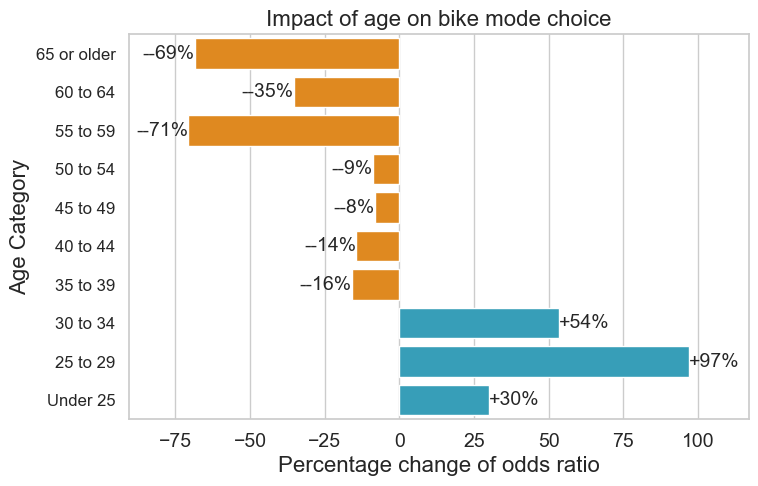

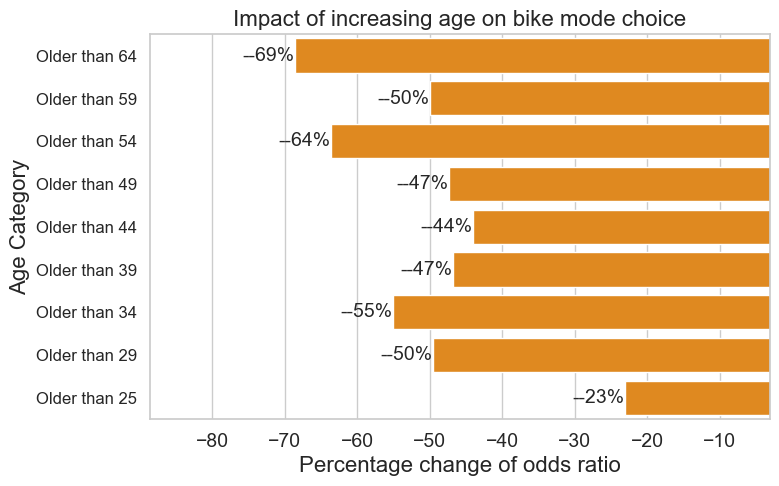

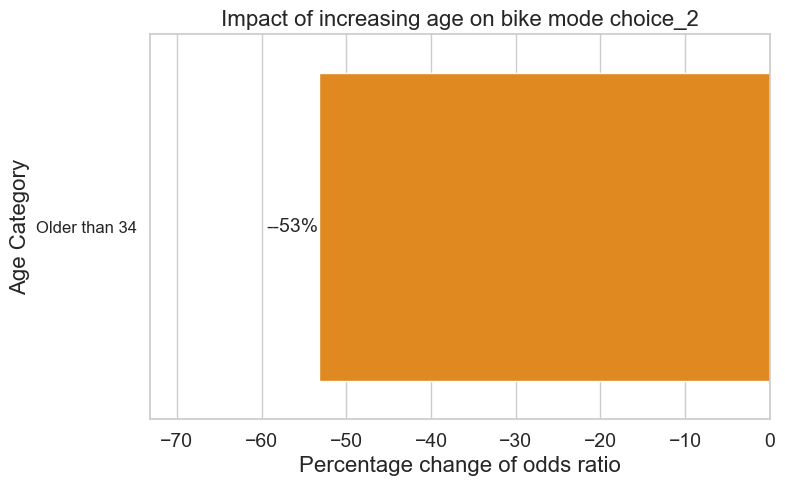

{'Under 25': 30.07820186151735, '25 to 29': 97.01419601858395, '30 to 34': 53.503080089247334, '35 to 39': -16.017664760561967, '40 to 44': -14.443247030363949, '45 to 49': -8.194067420014761, '50 to 54': -8.979899097705124, '55 to 59': -70.65211754956873, '60 to 64': -35.27822228756585, '65 or older': -68.61201725729423}
{'Older than 25': -23.12238512285013, 'Older than 29': -49.53960159939553, 'Older than 34': -55.04423320724368, 'Older than 39': -46.8571369842173, 'Older than 44': -44.05695392026118, 'Older than 49': -47.353675691504606, 'Older than 54': -63.69799757417972, 'Older than 59': -49.94383023012987, 'Older than 64': -68.61201725729423}


In [256]:
target = 'frequency of Bike or e-bike (non-bikeshare)'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))
insignificant_features = insignificant_features + ['business provide off-street bike parking spaces']

odds_ratio_age_cat = []
for i in range(0,df_bike_resampled_scaled['age'].max()+1):
    df_bike_age_cat = df_bike_resampled_scaled.copy()
    dict_age = {j: 1 if j == i else 0 for j in range(0, df_bike_resampled_scaled['age'].max()+1)}
    df_bike_age_cat['age'] = df_bike_age_cat['age'].map(dict_age)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_bike_age_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_age_cat.append((odds_ratios_sorted['age']-1)*100)


odds_ratio_age_cat_2 = []
for i in range(0,df_bike_resampled_scaled['age'].max()):
    df_bike_age_cat = df_bike_resampled_scaled.copy()
    dict_age = {j: 1 if j > i else 0 for j in range(0, df_bike_resampled_scaled['age'].max()+1)}
    df_bike_age_cat['age'] = df_bike_age_cat['age'].map(dict_age)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_bike_age_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_age_cat_2.append((odds_ratios_sorted['age']-1)*100)
    
# Create a dictionary to map age values to categories
age_categories = ["Under 25",
             "25 to 29",
             "30 to 34",
             "35 to 39",
             "40 to 44",
             "45 to 49",
             "50 to 54",
             "55 to 59",
             "60 to 64",
             "65 or older"]


age_categories_2 = ["Older than 25",
             "Older than 29",
             "Older than 34",
             "Older than 39",
             "Older than 44",
             "Older than 49",
             "Older than 54",
             "Older than 59",
             "Older than 64"]

odds_ratio_age_dict = {age_categories[i]: odds_ratio_age_cat[i] for i in range(0,len(odds_ratio_age_cat))}
odds_ratio_age_dict_2 = {age_categories_2[i]: odds_ratio_age_cat_2[i] for i in range(0,len(odds_ratio_age_cat_2))}

def plot_age_odds_ratio(age_categories, odds_ratio_age_dict, filename, limit=False, neg=False):
    # colors = sns.color_palette("mako", len(odds_ratio_age_dict))
    colors = ['#21abcd' if val >= 1 else '#ff8c00' for val in odds_ratio_age_dict.values()]
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.barplot(x=list(odds_ratio_age_dict.values()), y=list(odds_ratio_age_dict.keys()), ax=ax, palette=colors)
    plt.title(f'{filename}', fontsize=16)
    plt.xlabel('Percentage change of odds ratio', fontsize=16)
    plt.ylabel('Age Category', fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=14)
    ax.invert_yaxis()  # reverse the order of the y-axis

    # Add data labels to the plot
    for i, v in enumerate(odds_ratio_age_dict.values()):
        # Calculate the percentage increase or decrease in odds
        if v > 1:
            percentage_change = f'+{round(v)}%'
            ha = 'left'
            x_pos = v + 0.05
        else:
            percentage_change = f'-{round(v)}%'
            ha = 'right'
            x_pos = v - 0.05
        # Add the data label to the plot with percentage change
        plt.text(x_pos, i, f'{percentage_change}', ha=ha, va='center', fontsize=14)

    ax.set_xlim(left = min(odds_ratio_age_dict.values()) - 20, right=max(odds_ratio_age_dict.values()) + 20)
    if limit:
        ax.set_xlim(left = min(odds_ratio_age_dict.values()) - 20, right=0)
    if neg:
        ax.set_xlim(left = 0, right=max(odds_ratio_age_dict.values()) + 20)
        
    plt.savefig(f'{filename}.png', bbox_inches='tight', dpi=800)
    plt.show()
    
filename = 'Impact of age on bike mode choice'
plot_age_odds_ratio(age_categories, odds_ratio_age_dict, filename)

filename = 'Impact of increasing age on bike mode choice'
plot_age_odds_ratio(age_categories_2, odds_ratio_age_dict_2, filename)

filename = 'Impact of increasing age on bike mode choice_2'
odds_ratio_age_dict_3 = {'Older than 34': -53.19647705476046}
plot_age_odds_ratio('Older than 34', odds_ratio_age_dict_3, filename, limit=True)

print(odds_ratio_age_dict)
print(odds_ratio_age_dict_2)

### Sample Conclusions:
* **Secure bike parking:** an odds ratio of 7.64 means that commuters provided with secure bike parking are 7.64 times more likely to use bike. In other words, providing secure bike parking increases the likelihood of commuters to use bike by 664%.
* **gender_Male:** an odds ratio of 3.11 means that males are 3.11 times more likely to use bike compared to female. In other words, males are 211% more likely to commute by bike.

## Transit

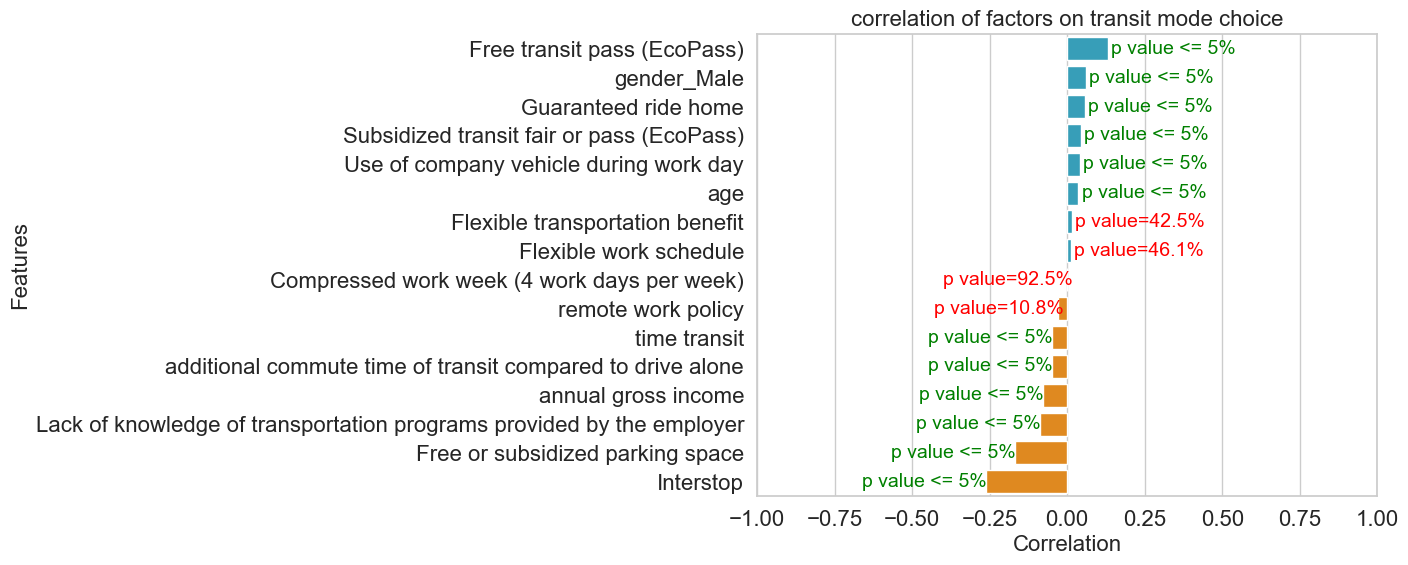

Free transit pass (EcoPass)                                              1.441476e-13
gender_Male                                                              7.145275e-04
Guaranteed ride home                                                     1.819290e-03
Subsidized transit fair or pass (EcoPass)                                1.368580e-02
Use of company vehicle during work day                                   1.898877e-02
age                                                                      4.261349e-02
Flexible transportation benefit                                          4.247080e-01
Flexible work schedule                                                   4.612086e-01
Compressed work week (4 work days per week)                              9.251142e-01
remote work policy                                                       1.077740e-01
time transit                                                             4.533009e-03
additional commute time of transit compared to drive a

In [257]:
filt = transportation_programs_shares['percentage (%)'] >= 5
programs = list(transportation_programs_shares[filt]['transportation programs'])

transit_related_cols = programs + ['annual gross income', 'age', 'gender_Male', 'time transit', 
       'Interstop','remote work policy',
       'frequency of Used Transit (bus and/or rail)']

items_to_remove = ['Secure bike parking','business provide off-street bike parking spaces']
for item in items_to_remove:
    transit_related_cols.remove(item)

# transit_related_cols = ['annual gross income', 'age', 'gender_Male',
#        'time transit', 'Interstop', 'remote work policy',
#        'Bike routes/maps and safety information/seminars',
#        'Secure bike parking', 'Free or subsidized parking space',
#        'Compressed work week (4 work days per week)',
#        'Carshare membership or credits', 'Preferred parking for carpool',
#        'Private employer shuttle', 'Subsidized transit fair or pass (EcoPass)',
#        'Flexible transportation benefit',
#        'Not knowing if the employer provides any transportation benefit',
#        'Prizes/drawings/contests for cash or other items for not driving alone',
#        'Use of company vehicle during work day', 'Guaranteed ride home',
#        'Free transit pass (EcoPass)', 'Carpool or Vanpool program',
#        'Bike commuting stipend', 'Flexible work schedule',
#        'E-scooter membership or credits',
#        'frequency of Used Transit (bus and/or rail)']


# create dataframe related to analyzing transit frequency
df_transit = df[transit_related_cols].copy()

# include additiona commute times
df_transit['additional commute time of transit compared to drive alone'] = df.loc[:, 'time transit'] - df.loc[:, 'time drive']

# check if you would like to change frequency to boolean
change_frequency_to_boolean = True
if change_frequency_to_boolean:
    df_transit = df_transit.loc[:, df_transit.columns]
    df_transit.loc[df_transit['frequency of Used Transit (bus and/or rail)'] > 0, 'frequency of Used Transit (bus and/or rail)'] = 1

# perform over sampleing to cure imbalance in data
target = 'frequency of Used Transit (bus and/or rail)'
df_transit_resampled = over_sampling(df_transit, target)

# scale data
columns_to_scale = ['time transit', 'additional commute time of transit compared to drive alone']
df_transit_resampled_scaled = minmax_scale_columns(df_transit_resampled,columns_to_scale)
df_transit_scaled = minmax_scale_columns(df_transit,columns_to_scale)


# plot the correlations
insignificant_features, sorted_correlations, sorted_p_values  = plot_correlation(df_transit_scaled, target, 'correlation of factors on transit mode choice')

sorted_p_values

In [258]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create an Excel writer object
writer = pd.ExcelWriter('contingency_tables.xlsx')

# Create a dictionary to store the chi-square and p-value results for each column
results_dict = {}

# Select the columns for the contingency table
cols = list(df_transit_scaled.columns)

# Loop through each column
for ind, col in enumerate(cols):
    if col == 'frequency of Used Transit (bus and/or rail)':
        continue
    # Create the contingency table
    cont_table = pd.crosstab(df_transit_scaled[col], df_transit_scaled['frequency of Used Transit (bus and/or rail)'])
    
#     print(cont_table)
    
    # Perform the chi-square test
    chi2, pval, dof, exp = chi2_contingency(cont_table)
    
    # Add the results to the dictionary
    results_dict[col] = {'chi2': chi2, 'pval': pval}

    # Write the contingency table to a new sheet in the Excel file
    cont_table.to_excel(writer, sheet_name=str(ind))
    

# Save the Excel file
# writer.save()

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results_dict, orient='index')

# Sort the DataFrame based on p-value in ascending order
results_df = results_df.sort_values(by='pval')


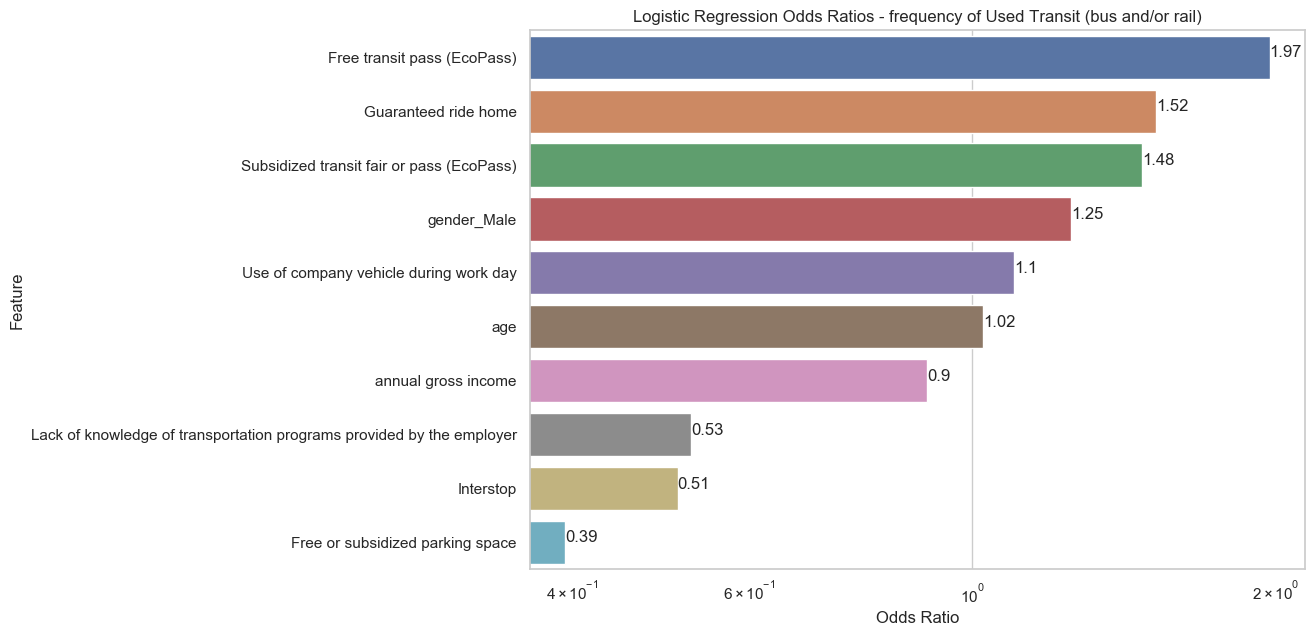

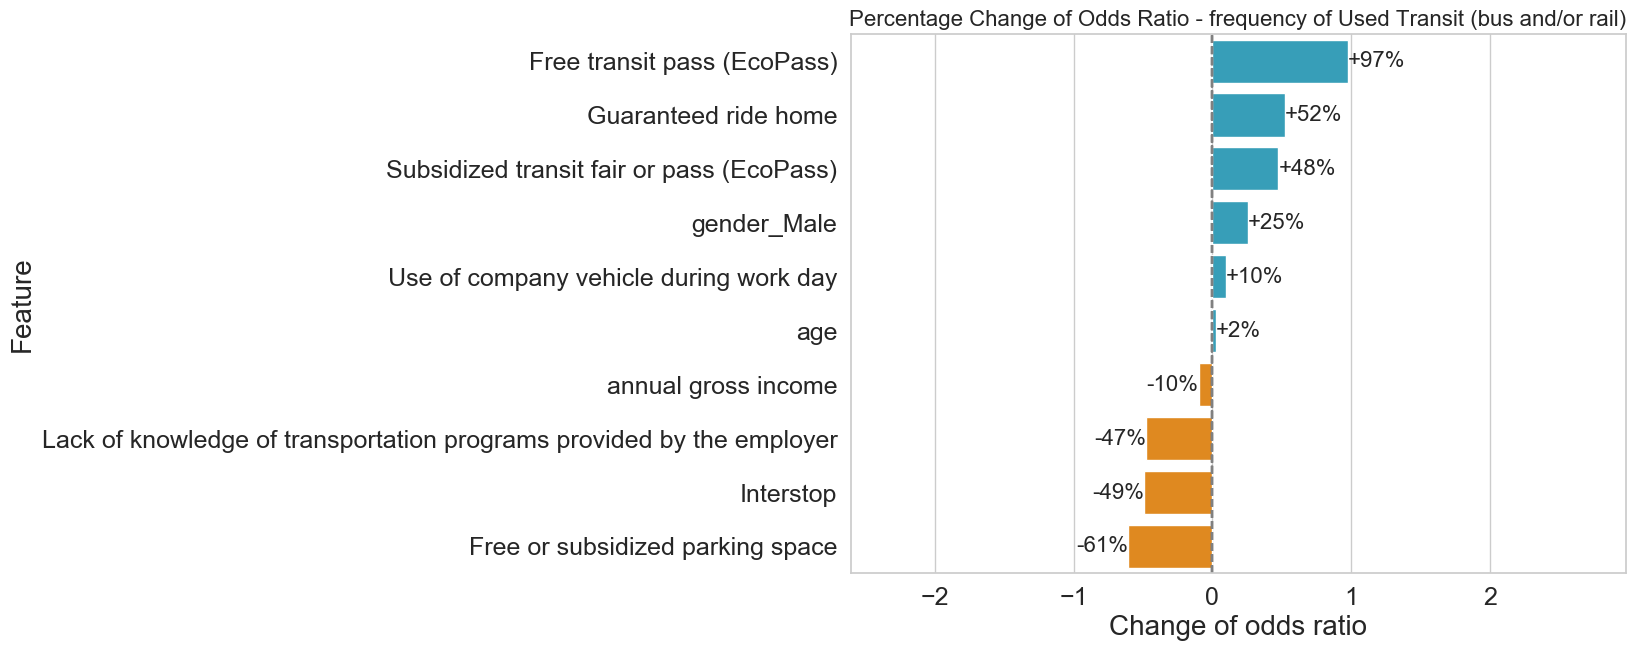

Free transit pass (EcoPass)                                              97.466823
Guaranteed ride home                                                     52.136196
Subsidized transit fair or pass (EcoPass)                                47.568568
gender_Male                                                              25.315954
Use of company vehicle during work day                                    9.930418
age                                                                       2.473811
annual gross income                                                      -9.905520
Lack of knowledge of transportation programs provided by the employer   -47.482678
Interstop                                                               -49.070505
Free or subsidized parking space                                        -60.627216
dtype: float64

In [259]:
file_name = 'Logistic Regression Odds Ratios for Transit Mode'
file_name_2 = 'Percentage Change of Odds Ratios for Transit Mode'
target = 'frequency of Used Transit (bus and/or rail)'


filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))

odds_ratios_sorted = multinomial_logistic_regression_odds_ratios(df_transit_resampled_scaled.drop(columns=insignificant_features), 
                                            target, file_name, file_name_2)

(odds_ratios_sorted-1)*100

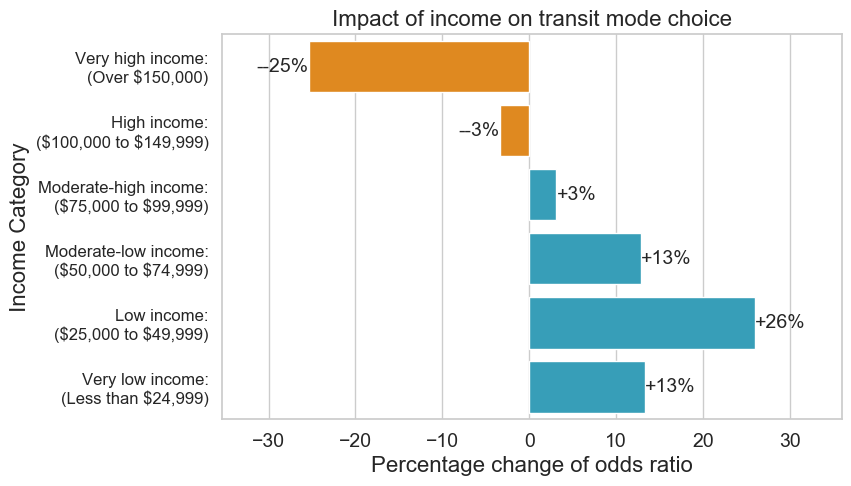

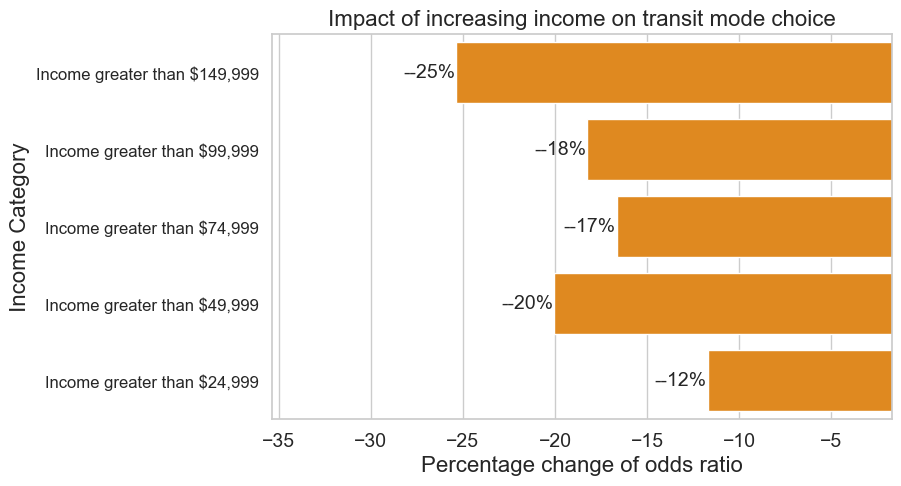

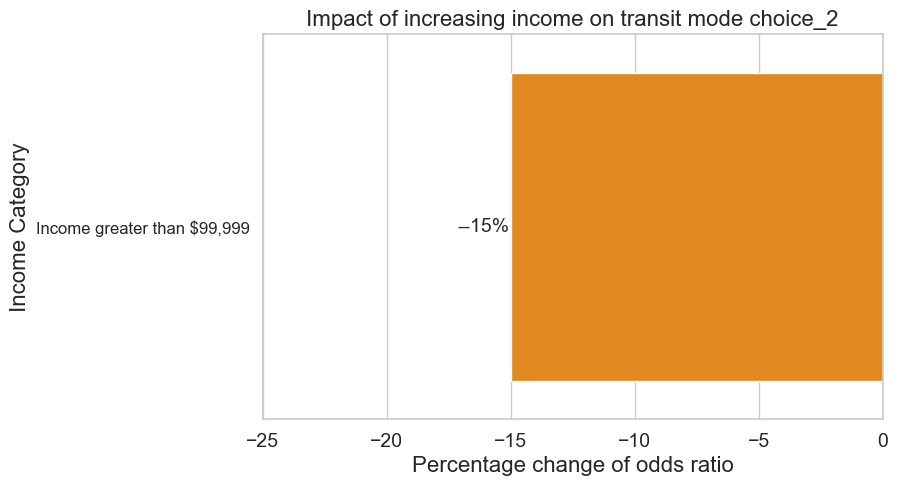

{'Very low income:\n(Less than $24,999)': 13.272239925432405, 'Low income:\n(\\$25,000 to $49,999)': 25.943397020502147, 'Moderate-low income:\n(\\$50,000 to $74,999)': 12.832865780261438, 'Moderate-high income:\n(\\$75,000 to $99,999)': 3.121284392823531, 'High income:\n(\\$100,000 to $149,999)': -3.389556671279237, 'Very high income:\n(Over $150,000)': -25.368819755427086}
{'Income greater than $24,999': -11.722008500436887, 'Income greater than $49,999': -20.03813980703535, 'Income greater than $74,999': -16.643211699351657, 'Income greater than $99,999': -18.25855325482606, 'Income greater than $149,999': -25.368819755427086}


In [260]:
target = 'frequency of Used Transit (bus and/or rail)'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))

odds_ratio_income_cat = []
for i in range(1,7):
    df_transit_income_cat = df_transit_resampled_scaled.copy()
    dict_income = dict_income = {j: 1 if j == i else 0 for j in range(1, 7)}
    df_transit_income_cat['annual gross income'] = df_transit_income_cat['annual gross income'].map(dict_income)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_transit_income_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_income_cat.append((odds_ratios_sorted['annual gross income']-1)*100)

    
odds_ratio_income_cat_2 = []
for i in range(1,6):
    df_transit_income_cat = df_transit_resampled_scaled.copy()
    dict_income = {j: 1 if j > i else 0 for j in range(1, 7)}
    df_transit_income_cat['annual gross income'] = df_transit_income_cat['annual gross income'].map(dict_income)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_transit_income_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_income_cat_2.append((odds_ratios_sorted['annual gross income']-1)*100)

# Create a dictionary to map income values to categories
income_categories = [
    'Very low income:\n(Less than $24,999)',
    'Low income:\n(\$25,000 to $49,999)',
    'Moderate-low income:\n(\$50,000 to $74,999)',
    'Moderate-high income:\n(\$75,000 to $99,999)',
    'High income:\n(\$100,000 to $149,999)',
    'Very high income:\n(Over $150,000)'
]

income_categories_2 = [
    'Income greater than $24,999',
    'Income greater than $49,999',
    'Income greater than $74,999',
    'Income greater than $99,999',
    'Income greater than $149,999'
]

odds_ratio_income_dict = {income_categories[i]: odds_ratio_income_cat[i] for i in range(0,len(odds_ratio_income_cat))}
odds_ratio_income_dict_2 = {income_categories_2[i]: odds_ratio_income_cat_2[i] for i in range(0,len(odds_ratio_income_cat_2))}

filename = 'Impact of income on transit mode choice'
plot_income_odds_ratio(income_categories, odds_ratio_income_dict, filename)


filename = 'Impact of increasing income on transit mode choice'
plot_income_odds_ratio(income_categories_2, odds_ratio_income_dict_2, filename)

filename = 'Impact of increasing income on transit mode choice_2'
odds_ratio_income_dict_3 = {'Income greater than $99,999': -15}
plot_income_odds_ratio(income_categories_2[3], odds_ratio_income_dict_3, filename, limit=True, neg=True)

print(odds_ratio_income_dict)
print(odds_ratio_income_dict_2)

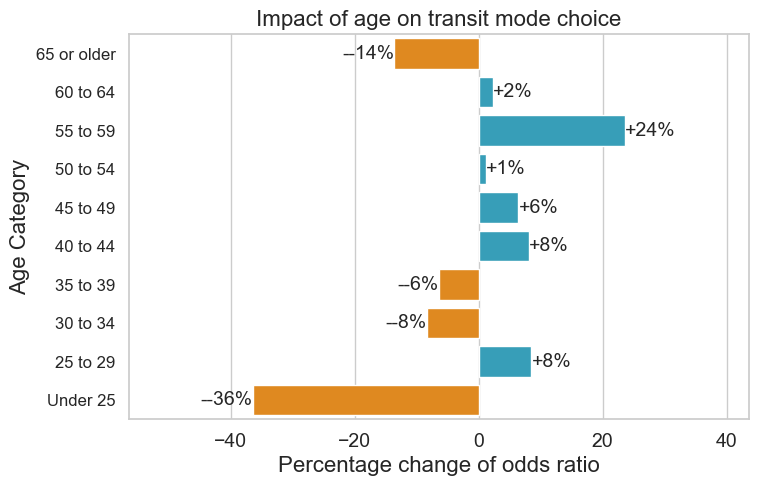

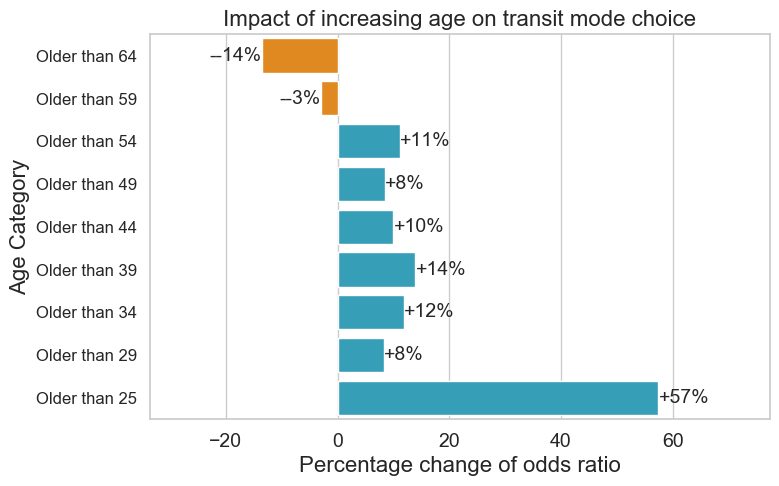

{'Under 25': -36.446004660619636, '25 to 29': 8.478017265308901, '30 to 34': -8.319893157107183, '35 to 39': -6.382310588462259, '40 to 44': 8.063715493763768, '45 to 49': 6.357382092014219, '50 to 54': 1.1511739834259238, '55 to 59': 23.52426097974847, '60 to 64': 2.24132657371261, '65 or older': -13.61192162435959}
{'Older than 25': 57.366462925642026, 'Older than 29': 8.244373565729667, 'Older than 34': 11.857069418816547, 'Older than 39': 13.902831927006343, 'Older than 44': 9.946711608324431, 'Older than 49': 8.436106922278697, 'Older than 54': 11.103880311419246, 'Older than 59': -2.9789596371667226, 'Older than 64': -13.61192162435959}


In [261]:
target = 'frequency of Used Transit (bus and/or rail)'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))

odds_ratio_age_cat = []
for i in range(0,df_transit_resampled_scaled['age'].max()+1):
    df_transit_age_cat = df_transit_resampled_scaled.copy()
    dict_age = {j: 1 if j == i else 0 for j in range(0, df_transit_resampled_scaled['age'].max()+1)}
    df_transit_age_cat['age'] = df_transit_age_cat['age'].map(dict_age)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_transit_age_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_age_cat.append((odds_ratios_sorted['age']-1)*100)


odds_ratio_age_cat_2 = []
for i in range(0,df_transit_resampled_scaled['age'].max()):
    df_transit_age_cat = df_transit_resampled_scaled.copy()
    dict_age = {j: 1 if j > i else 0 for j in range(0, df_transit_resampled_scaled['age'].max()+1)}
    df_transit_age_cat['age'] = df_transit_age_cat['age'].map(dict_age)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_transit_age_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_age_cat_2.append((odds_ratios_sorted['age']-1)*100)
    
# Create a dictionary to map age values to categories
age_categories = ["Under 25",
             "25 to 29",
             "30 to 34",
             "35 to 39",
             "40 to 44",
             "45 to 49",
             "50 to 54",
             "55 to 59",
             "60 to 64",
             "65 or older"]


age_categories_2 = ["Older than 25",
             "Older than 29",
             "Older than 34",
             "Older than 39",
             "Older than 44",
             "Older than 49",
             "Older than 54",
             "Older than 59",
             "Older than 64"]

odds_ratio_age_dict = {age_categories[i]: odds_ratio_age_cat[i] for i in range(0,len(odds_ratio_age_cat))}
odds_ratio_age_dict_2 = {age_categories_2[i]: odds_ratio_age_cat_2[i] for i in range(0,len(odds_ratio_age_cat_2))}

filename = 'Impact of age on transit mode choice'
plot_age_odds_ratio(age_categories, odds_ratio_age_dict, filename)


filename = 'Impact of increasing age on transit mode choice'
plot_age_odds_ratio(age_categories_2, odds_ratio_age_dict_2, filename)

print(odds_ratio_age_dict)
print(odds_ratio_age_dict_2)

### Sample Conclusions:
* **Free transit pass:** An odds ratio of 1.92 for a free transit pass on whether people use transit or not means that people who have a free transit pass are 1.92 times more likely to use transit compared to people who do not have a free transit pass. In other words, providing free transit pass increases the likelihood of using transit by 92%. Compared to **Subsidized transit fair or pass** with odds ratio of 1.47, people are nearly 1.3 (=1.92/1.47) times more likely to use transit.

* **Interstop:** An odds ratio of 0.51 for interstop on whether people use transit or not means that people with interstop are 0.51 times less likely to use transit compared to poepl with no interstop. In other words, having interstop reduces the likelihood of using transit by 49%.

## Drive Alone

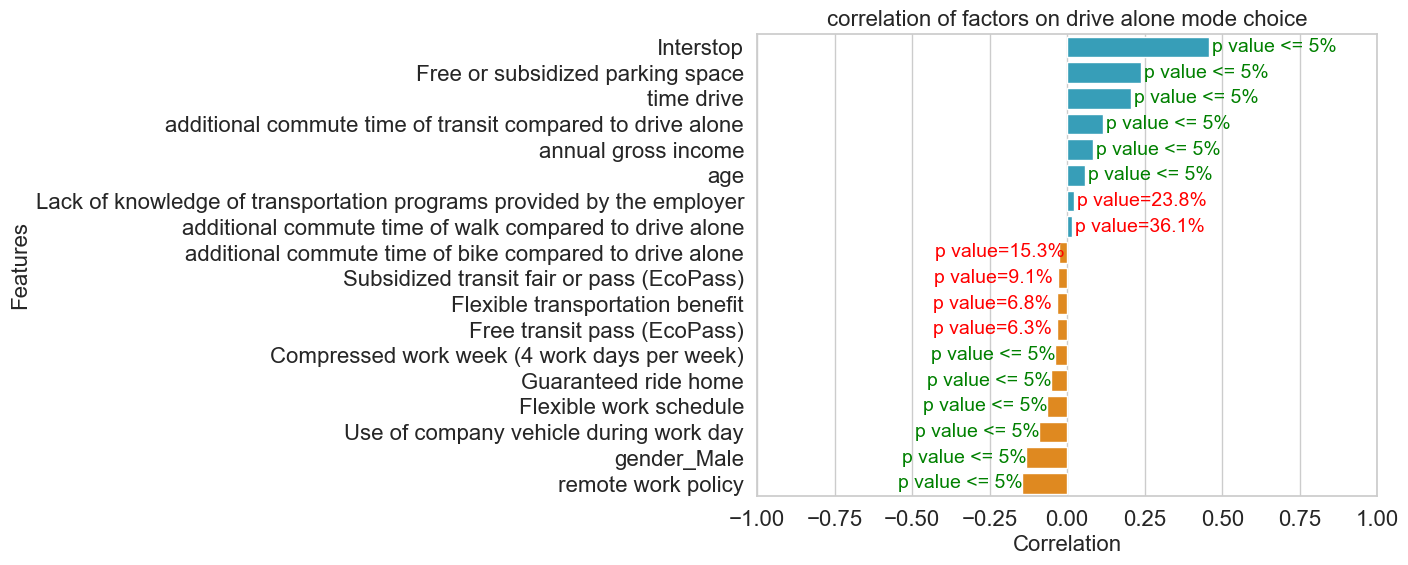

Interstop                                                                2.828194e-162
Free or subsidized parking space                                          3.512149e-41
time drive                                                                1.909301e-31
additional commute time of transit compared to drive alone                1.400087e-10
annual gross income                                                       3.403437e-06
age                                                                       1.224450e-03
Lack of knowledge of transportation programs provided by the employer     2.381007e-01
additional commute time of walk compared to drive alone                   3.607898e-01
additional commute time of bike compared to drive alone                   1.532583e-01
Subsidized transit fair or pass (EcoPass)                                 9.132670e-02
Flexible transportation benefit                                           6.829308e-02
Free transit pass (EcoPass)                

In [262]:
filt = transportation_programs_shares['percentage (%)'] >= 5
programs = list(transportation_programs_shares[filt]['transportation programs'])

drive_related_cols = programs + ['annual gross income', 'age', 'gender_Male', 'time drive', 
       'Interstop','remote work policy',
       'frequency of Drive alone']

items_to_remove = ['Secure bike parking','business provide off-street bike parking spaces']
for item in items_to_remove:
    drive_related_cols.remove(item)


# create dataframe related to analyzing drive alone frequency
df_drive = df[drive_related_cols].copy()

# include additiona commute times
df_drive['additional commute time of transit compared to drive alone'] = df.loc[:, 'time transit'] - df.loc[:, 'time drive']
df_drive['additional commute time of bike compared to drive alone'] = df.loc[:, 'time bike'] - df.loc[:, 'time drive']
df_drive['additional commute time of walk compared to drive alone'] = df.loc[:, 'time walk'] - df.loc[:, 'time drive']

# check if you would like to change frequency to boolean
change_frequency_to_boolean = True
if change_frequency_to_boolean:
    df_drive = df_drive.loc[:, df_drive.columns]
    df_drive.loc[df_drive['frequency of Drive alone'] > 0, 'frequency of Drive alone'] = 1

# perform over sampleing to cure imbalance in data
target = 'frequency of Drive alone'
df_drive_resampled = over_sampling(df_drive, target)

# scale data
columns_to_scale = ['time drive', 'additional commute time of transit compared to drive alone', 'additional commute time of bike compared to drive alone','additional commute time of walk compared to drive alone']
df_drive_resampled_scaled = minmax_scale_columns(df_drive_resampled, columns_to_scale)
df_drive_scaled = minmax_scale_columns(df_drive, columns_to_scale)


# plot the correlations
insignificant_features, sorted_correlations, sorted_p_values = plot_correlation(df_drive_scaled, target, 'correlation of factors on drive alone mode choice')

sorted_p_values

In [263]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create an Excel writer object
writer = pd.ExcelWriter('contingency_tables.xlsx')

# Create a dictionary to store the chi-square and p-value results for each column
results_dict = {}

# Select the columns for the contingency table
cols = list(df_drive_scaled.columns)

# Loop through each column
for ind, col in enumerate(cols):
    if col == 'frequency of Drive alone':
        continue
    # Create the contingency table
    cont_table = pd.crosstab(df_drive_scaled[col], df_drive_scaled['frequency of Drive alone'])
    
#     print(cont_table)
    
    # Perform the chi-square test
    chi2, pval, dof, exp = chi2_contingency(cont_table)
    
    # Add the results to the dictionary
    results_dict[col] = {'chi2': chi2, 'pval': pval}

    # Write the contingency table to a new sheet in the Excel file
    cont_table.to_excel(writer, sheet_name=str(ind))
    

# Save the Excel file
# writer.save()

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results_dict, orient='index')

# Sort the DataFrame based on p-value in ascending order
results_df = results_df.sort_values(by='pval')


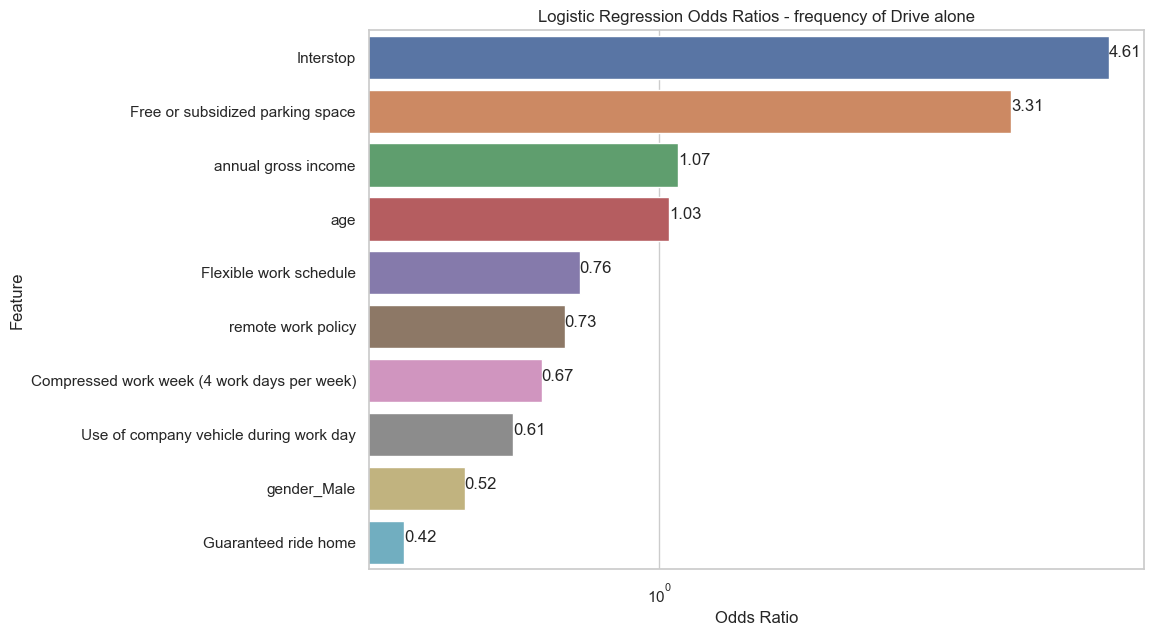

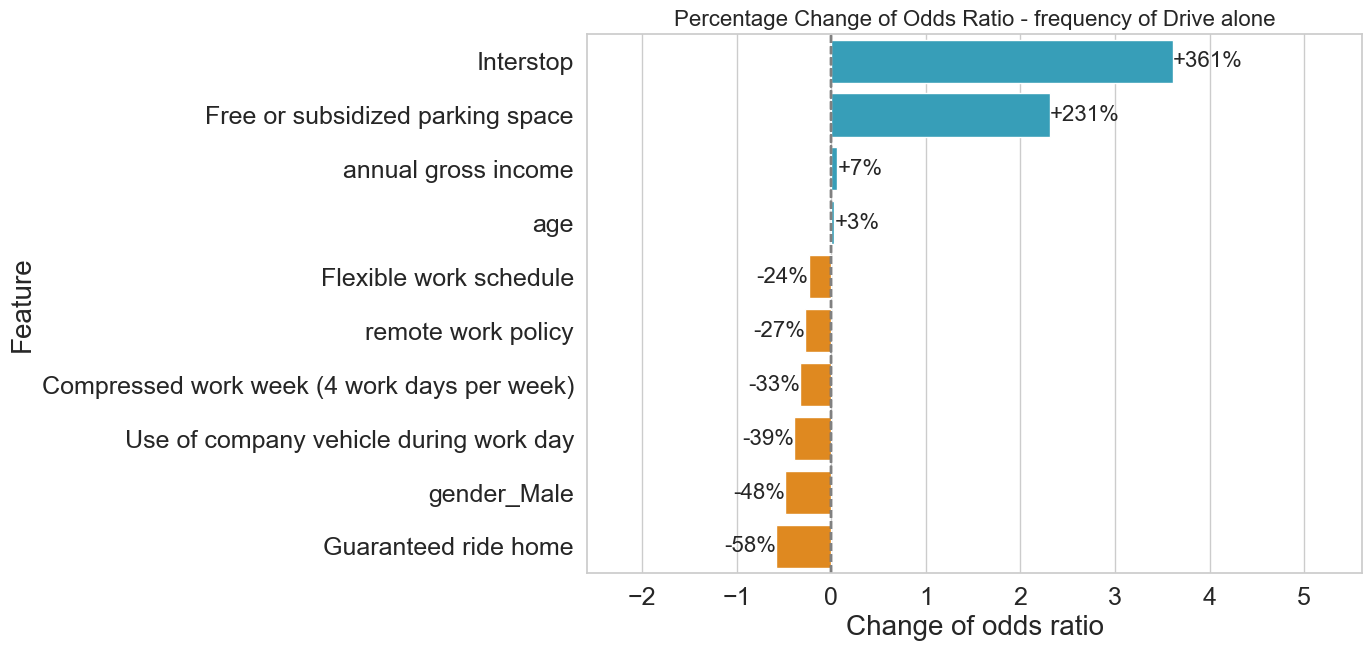

Interstop                                      361.325707
Free or subsidized parking space               230.892797
annual gross income                              6.724325
age                                              3.471618
Flexible work schedule                         -23.680871
remote work policy                             -27.490674
Compressed work week (4 work days per week)    -32.951261
Use of company vehicle during work day         -39.168063
gender_Male                                    -48.396494
Guaranteed ride home                           -57.954957
dtype: float64

In [264]:
file_name = 'Logistic Regression Odds Ratios for Drive Alone Mode'
file_name_2 = 'Percentage Change of Odds Ratios for Drive Alone Mode'
target = 'frequency of Drive alone'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))

odds_ratios_sorted = multinomial_logistic_regression_odds_ratios(df_drive_resampled_scaled.drop(columns=insignificant_features), 
                                            target, file_name, file_name_2)
(odds_ratios_sorted-1)*100

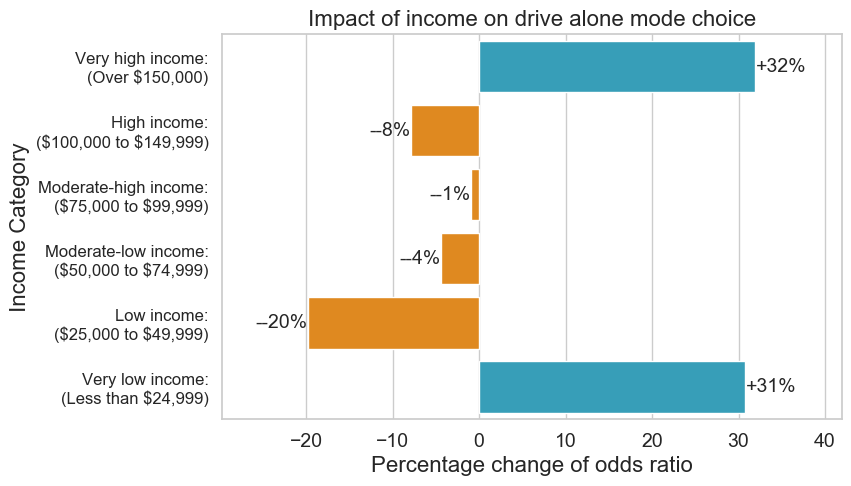

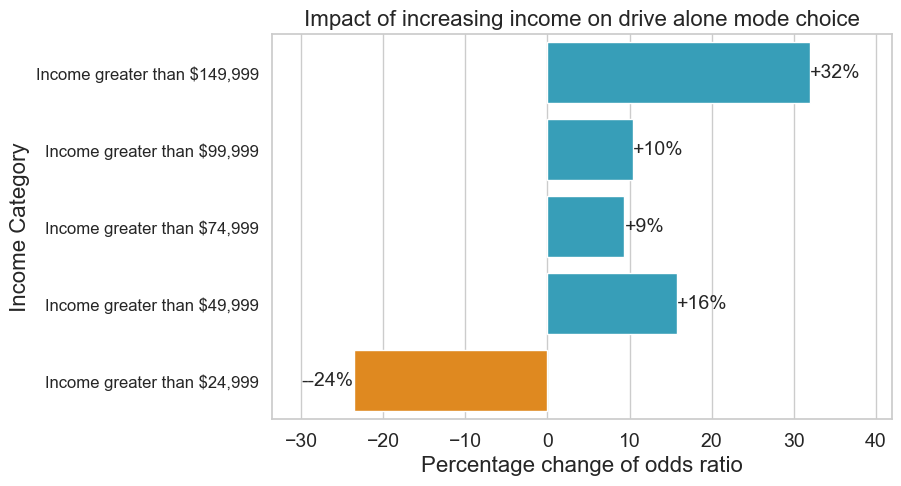

{'Very low income:\n(Less than $24,999)': 30.80487554214495, 'Low income:\n(\\$25,000 to $49,999)': -19.747256144206926, 'Moderate-low income:\n(\\$50,000 to $74,999)': -4.425677183402232, 'Moderate-high income:\n(\\$75,000 to $99,999)': -0.9861707639430839, 'High income:\n(\\$100,000 to $149,999)': -7.853958447737308, 'Very high income:\n(Over $150,000)': 31.945988329154428}
{'Income greater than $24,999': -23.561080805928224, 'Income greater than $49,999': 15.769221618601925, 'Income greater than $74,999': 9.374573938900443, 'Income greater than $99,999': 10.366351171499911, 'Income greater than $149,999': 31.945988329154428}


In [265]:
target = 'frequency of Drive alone'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))

odds_ratio_income_cat = []
for i in range(1,7):
    df_drive_income_cat = df_drive_resampled_scaled.copy()
    dict_income = dict_income = {j: 1 if j == i else 0 for j in range(1, 7)}
    df_drive_income_cat['annual gross income'] = df_drive_income_cat['annual gross income'].map(dict_income)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_drive_income_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_income_cat.append((odds_ratios_sorted['annual gross income']-1)*100)

odds_ratio_income_cat_2 = []
for i in range(1,6):
    df_drive_income_cat = df_drive_resampled_scaled.copy()
    dict_income = {j: 1 if j > i else 0 for j in range(1, 7)}
    df_drive_income_cat['annual gross income'] = df_drive_income_cat['annual gross income'].map(dict_income)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_drive_income_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_income_cat_2.append((odds_ratios_sorted['annual gross income']-1)*100)

# Create a dictionary to map income values to categories
income_categories = [
    'Very low income:\n(Less than $24,999)',
    'Low income:\n(\$25,000 to $49,999)',
    'Moderate-low income:\n(\$50,000 to $74,999)',
    'Moderate-high income:\n(\$75,000 to $99,999)',
    'High income:\n(\$100,000 to $149,999)',
    'Very high income:\n(Over $150,000)'
]

income_categories_2 = [
    'Income greater than $24,999',
    'Income greater than $49,999',
    'Income greater than $74,999',
    'Income greater than $99,999',
    'Income greater than $149,999'
]

odds_ratio_income_dict = {income_categories[i]: odds_ratio_income_cat[i] for i in range(0,len(odds_ratio_income_cat))}
odds_ratio_income_dict_2 = {income_categories_2[i]: odds_ratio_income_cat_2[i] for i in range(0,len(odds_ratio_income_cat_2))}

filename = 'Impact of income on drive alone mode choice'
plot_income_odds_ratio(income_categories, odds_ratio_income_dict, filename)

filename = 'Impact of increasing income on drive alone mode choice'
plot_income_odds_ratio(income_categories_2, odds_ratio_income_dict_2, filename)

print(odds_ratio_income_dict)
print(odds_ratio_income_dict_2)

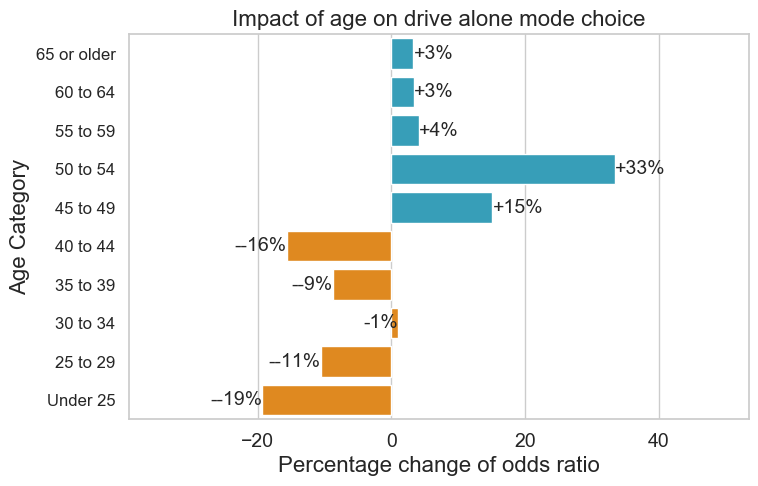

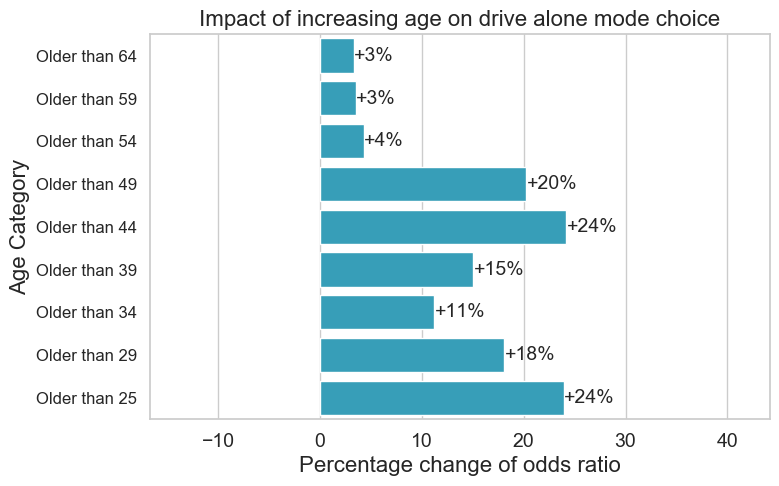

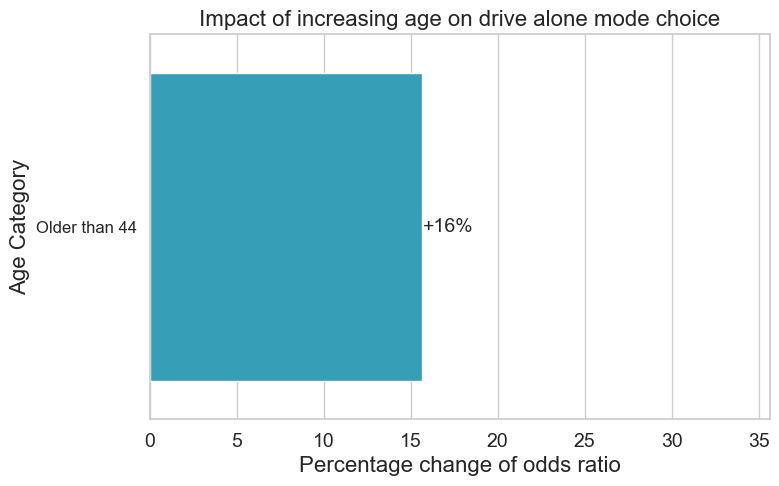

{'Under 25': -19.28338056228388, '25 to 29': -10.603297399088396, '30 to 34': 0.9977011646031819, '35 to 39': -8.80959285317795, '40 to 44': -15.610018586154506, '45 to 49': 15.061130901828568, '50 to 54': 33.419375197863374, '55 to 59': 4.087667753871771, '60 to 64': 3.3092815084348137, '65 or older': 3.292465825170643}
{'Older than 25': 23.91653134266796, 'Older than 29': 18.093461529739805, 'Older than 34': 11.233967409249423, 'Older than 39': 15.051481411543843, 'Older than 44': 24.171452938468875, 'Older than 49': 20.26367062871861, 'Older than 54': 4.294688767400978, 'Older than 59': 3.49119769030537, 'Older than 64': 3.292465825170643}


In [266]:
target = 'frequency of Drive alone'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))

odds_ratio_age_cat = []
for i in range(0,df_drive_resampled_scaled['age'].max()+1):
    df_drive_age_cat = df_drive_resampled_scaled.copy()
    dict_age = {j: 1 if j == i else 0 for j in range(0, df_drive_resampled_scaled['age'].max()+1)}
    df_drive_age_cat['age'] = df_drive_age_cat['age'].map(dict_age)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_drive_age_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_age_cat.append((odds_ratios_sorted['age']-1)*100)


odds_ratio_age_cat_2 = []
for i in range(0,df_drive_resampled_scaled['age'].max()):
    df_drive_age_cat = df_drive_resampled_scaled.copy()
    dict_age = {j: 1 if j > i else 0 for j in range(0, df_drive_resampled_scaled['age'].max()+1)}
    df_drive_age_cat['age'] = df_drive_age_cat['age'].map(dict_age)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_drive_age_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_age_cat_2.append((odds_ratios_sorted['age']-1)*100)
    
# Create a dictionary to map age values to categories
age_categories = ["Under 25",
             "25 to 29",
             "30 to 34",
             "35 to 39",
             "40 to 44",
             "45 to 49",
             "50 to 54",
             "55 to 59",
             "60 to 64",
             "65 or older"]


age_categories_2 = ["Older than 25",
             "Older than 29",
             "Older than 34",
             "Older than 39",
             "Older than 44",
             "Older than 49",
             "Older than 54",
             "Older than 59",
             "Older than 64"]

odds_ratio_age_dict = {age_categories[i]: odds_ratio_age_cat[i] for i in range(0,len(odds_ratio_age_cat))}
odds_ratio_age_dict_2 = {age_categories_2[i]: odds_ratio_age_cat_2[i] for i in range(0,len(odds_ratio_age_cat_2))}

filename = 'Impact of age on drive alone mode choice'
plot_age_odds_ratio(age_categories, odds_ratio_age_dict, filename)


filename = 'Impact of increasing age on drive alone mode choice'
plot_age_odds_ratio(age_categories_2, odds_ratio_age_dict_2, filename)


filename = 'Impact of increasing age on drive alone mode choice'
odds_ratio_age_dict_3 = {'Older than 44': 15.645321267701684}
plot_age_odds_ratio('Older than 44', odds_ratio_age_dict_3, filename, limit=True, neg=True)

print(odds_ratio_age_dict)
print(odds_ratio_age_dict_2)

In [267]:
odds_ratio_age_dict_2

{'Older than 25': 23.91653134266796,
 'Older than 29': 18.093461529739805,
 'Older than 34': 11.233967409249423,
 'Older than 39': 15.051481411543843,
 'Older than 44': 24.171452938468875,
 'Older than 49': 20.26367062871861,
 'Older than 54': 4.294688767400978,
 'Older than 59': 3.49119769030537,
 'Older than 64': 3.292465825170643}

## Telecommute

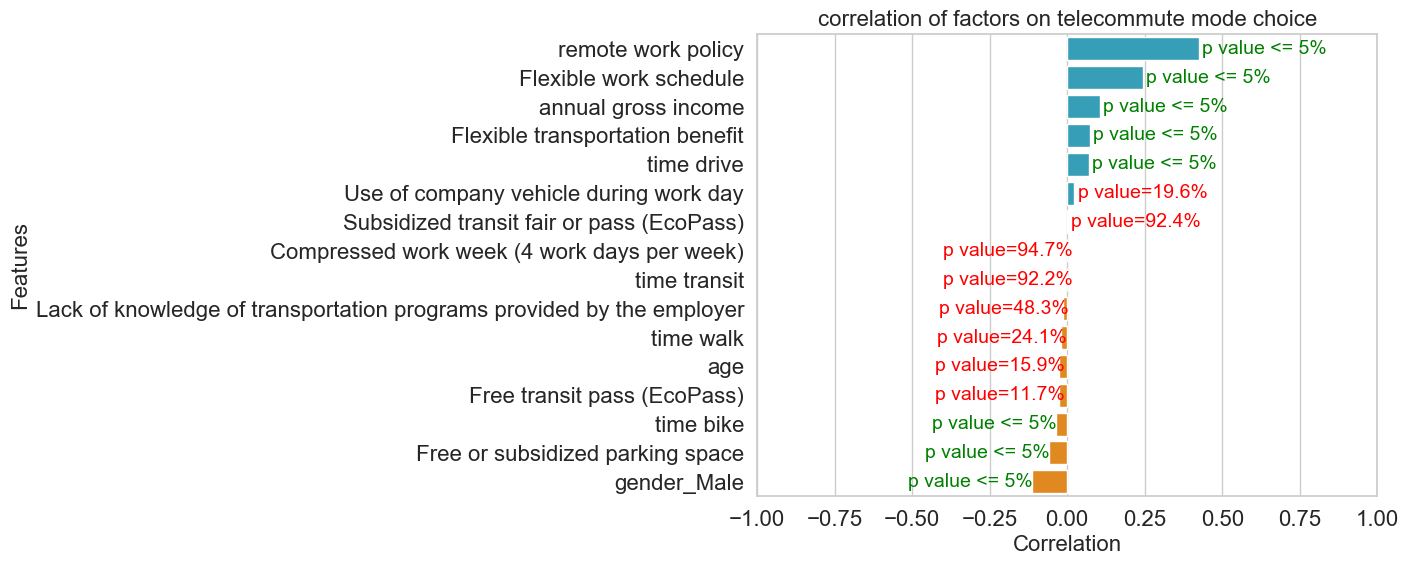

remote work policy                                                       9.642740e-137
Flexible work schedule                                                    3.351797e-44
annual gross income                                                       2.543379e-09
Flexible transportation benefit                                           5.614970e-05
time drive                                                                1.212179e-04
Use of company vehicle during work day                                    1.959001e-01
Subsidized transit fair or pass (EcoPass)                                 9.239078e-01
Compressed work week (4 work days per week)                               9.472383e-01
time transit                                                              9.223280e-01
Lack of knowledge of transportation programs provided by the employer     4.829019e-01
time walk                                                                 2.407435e-01
age                                        

In [268]:
filt = transportation_programs_shares['percentage (%)'] >= 5
programs = list(transportation_programs_shares[filt]['transportation programs'])

telecommute_related_cols = programs + ['annual gross income', 'age', 'gender_Male', 
                                       'time drive', 'time transit', 'time walk', 'time bike',
                                       'Interstop','remote work policy',
                                       'frequency of Telecommute (worked from home)']

items_to_remove = ['Secure bike parking',
                   'business provide off-street bike parking spaces', 
                   'Interstop', 'Guaranteed ride home']
for item in items_to_remove:
    telecommute_related_cols.remove(item)


# create dataframe related to analyzing drive alone frequency
df_telecommute = df[telecommute_related_cols].copy()

# check if you would like to change frequency to boolean
change_frequency_to_boolean = True
if change_frequency_to_boolean:
    df_telecommute = df_telecommute.loc[:, df_telecommute.columns]
    df_telecommute.loc[df_telecommute['frequency of Telecommute (worked from home)'] > 0, 'frequency of Telecommute (worked from home)'] = 1

# perform over sampleing to cure imbalance in data
target = 'frequency of Telecommute (worked from home)'
df_telecommute_resampled = over_sampling(df_telecommute, target)

# scale data
columns_to_scale = ['time drive', 'time bike', 'time walk', 'time transit']
df_telecommute_resampled_scaled = minmax_scale_columns(df_telecommute_resampled, columns_to_scale)
df_telecommute_scaled = minmax_scale_columns(df_telecommute, columns_to_scale)


# plot the correlations
insignificant_features, sorted_correlations, sorted_p_values = plot_correlation(df_telecommute_scaled, target, 'correlation of factors on telecommute mode choice')

sorted_p_values

In [269]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create an Excel writer object
writer = pd.ExcelWriter('contingency_tables.xlsx')

# Create a dictionary to store the chi-square and p-value results for each column
results_dict = {}

# Select the columns for the contingency table
cols = list(df_telecommute_scaled.columns)

# Loop through each column
for ind, col in enumerate(cols):
    if col == 'frequency of Telecommute (worked from home)':
        continue
    # Create the contingency table
    cont_table = pd.crosstab(df_telecommute_scaled[col], df_telecommute_scaled['frequency of Telecommute (worked from home)'])
    
#     print(cont_table)
    
    # Perform the chi-square test
    chi2, pval, dof, exp = chi2_contingency(cont_table)
    
    # Add the results to the dictionary
    results_dict[col] = {'chi2': chi2, 'pval': pval}

    # Write the contingency table to a new sheet in the Excel file
    cont_table.to_excel(writer, sheet_name=str(ind))
    

# Save the Excel file
# writer.save()

# Create a Pandas DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results_dict, orient='index')

# Sort the DataFrame based on p-value in ascending order
results_df = results_df.sort_values(by='pval')


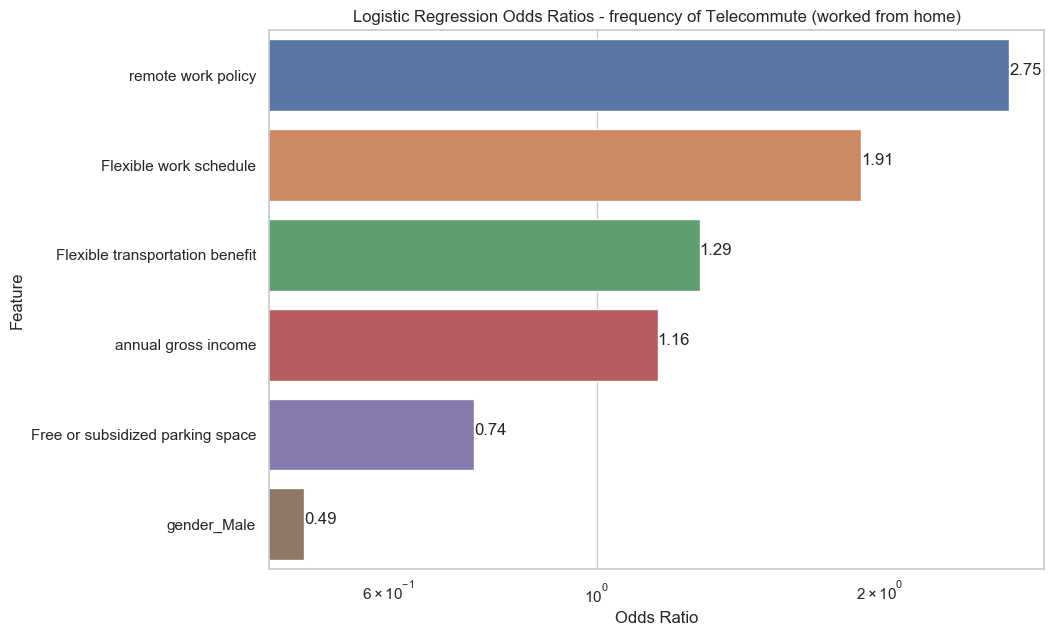

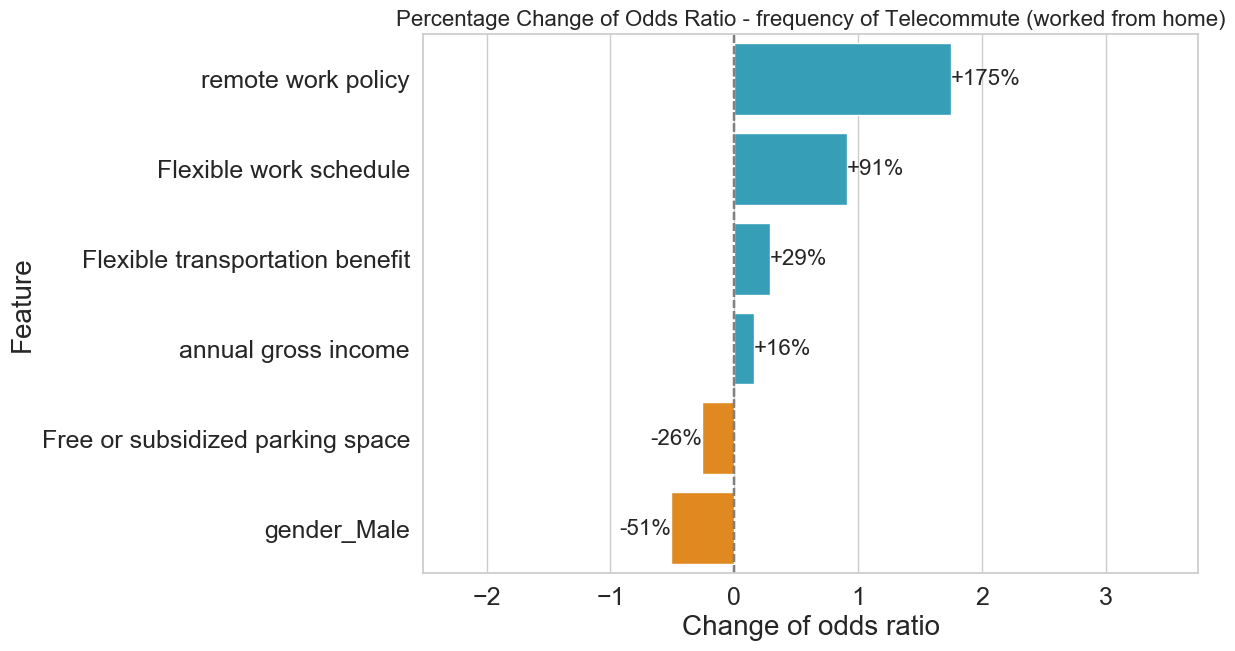

remote work policy                  174.521657
Flexible work schedule               91.026485
Flexible transportation benefit      28.616374
annual gross income                  16.075804
Free or subsidized parking space    -25.940481
gender_Male                         -51.139653
dtype: float64

In [270]:
file_name = 'Logistic Regression Odds Ratios for Telecommute Mode'
file_name_2 = 'Percentage Change of Odds Ratios for Telecommute Mode'
target = 'frequency of Telecommute (worked from home)'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))

odds_ratios_sorted = multinomial_logistic_regression_odds_ratios(df_telecommute_resampled_scaled.drop(columns=insignificant_features), 
                                            target, file_name, file_name_2)
(odds_ratios_sorted-1)*100

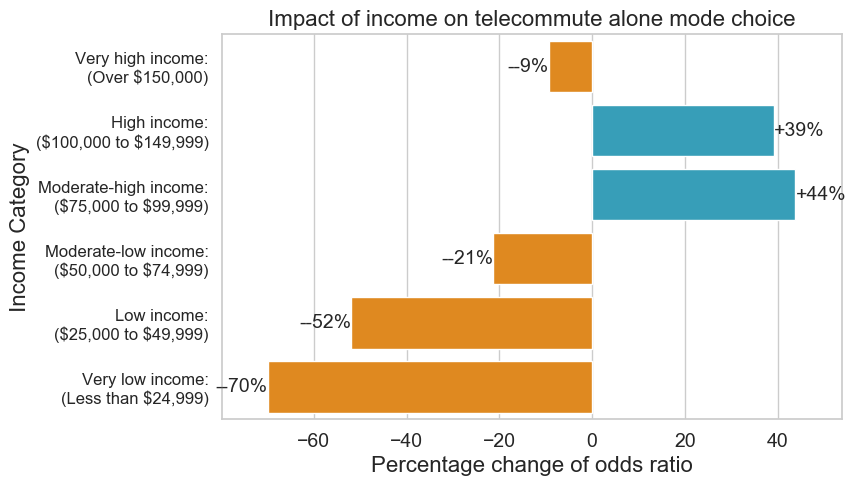

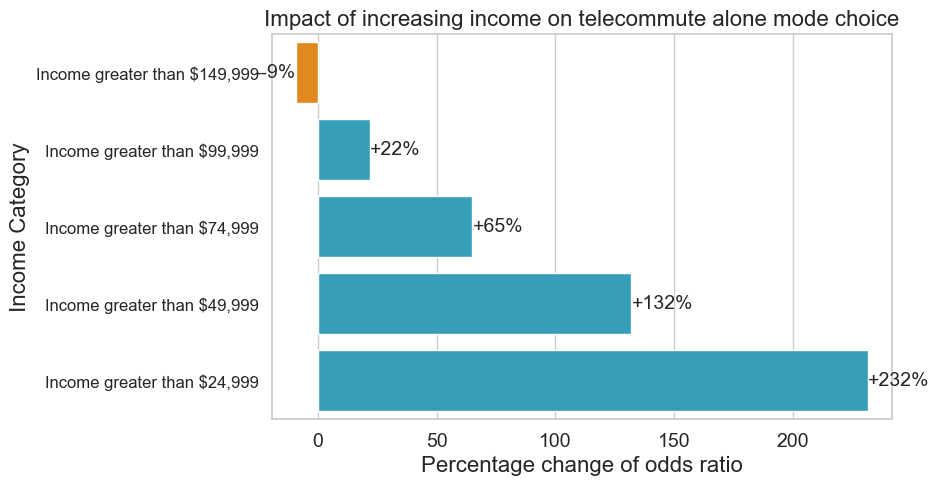

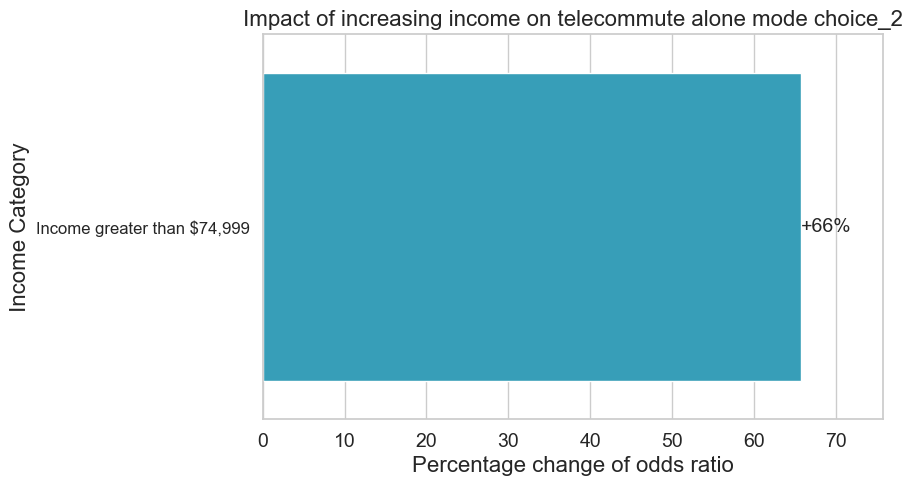

{'Very low income:\n(Less than $24,999)': -69.84794701932368, 'Low income:\n(\\$25,000 to $49,999)': -51.93397700088611, 'Moderate-low income:\n(\\$50,000 to $74,999)': -21.3151545578402, 'Moderate-high income:\n(\\$75,000 to $99,999)': 43.83511842155041, 'High income:\n(\\$100,000 to $149,999)': 39.18944091136145, 'Very high income:\n(Over $150,000)': -9.334271563448826}
{'Income greater than $24,999': 231.63234095758122, 'Income greater than $49,999': 131.95956848681044, 'Income greater than $74,999': 65.1243869317167, 'Income greater than $99,999': 22.016666858144763, 'Income greater than $149,999': -9.334271563448826}


In [271]:
target = 'frequency of Telecommute (worked from home)'

filt = results_df['pval']>0.05
insignificant_features = list(set(list(results_df[filt].index) + insignificant_features))

odds_ratio_income_cat = []
for i in range(1,7):
    df_telecommute_income_cat = df_telecommute_resampled_scaled.copy()
    dict_income = dict_income = {j: 1 if j == i else 0 for j in range(1, 7)}
    df_telecommute_income_cat['annual gross income'] = df_telecommute_income_cat['annual gross income'].map(dict_income)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_telecommute_income_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_income_cat.append((odds_ratios_sorted['annual gross income']-1)*100)

odds_ratio_income_cat_2 = []
for i in range(1,6):
    df_telecommute_income_cat = df_telecommute_resampled_scaled.copy()
    dict_income = {j: 1 if j > i else 0 for j in range(1, 7)}
    df_telecommute_income_cat['annual gross income'] = df_telecommute_income_cat['annual gross income'].map(dict_income)
    odds_ratios_sorted = multinomial_logistic_regression_income_groups(df_telecommute_income_cat.drop(columns=insignificant_features), 
                                            target)
    odds_ratio_income_cat_2.append((odds_ratios_sorted['annual gross income']-1)*100)

# Create a dictionary to map income values to categories
income_categories = [
    'Very low income:\n(Less than $24,999)',
    'Low income:\n(\$25,000 to $49,999)',
    'Moderate-low income:\n(\$50,000 to $74,999)',
    'Moderate-high income:\n(\$75,000 to $99,999)',
    'High income:\n(\$100,000 to $149,999)',
    'Very high income:\n(Over $150,000)'
]

income_categories_2 = [
    'Income greater than $24,999',
    'Income greater than $49,999',
    'Income greater than $74,999',
    'Income greater than $99,999',
    'Income greater than $149,999'
]

odds_ratio_income_dict = {income_categories[i]: odds_ratio_income_cat[i] for i in range(0,len(odds_ratio_income_cat))}
odds_ratio_income_dict_2 = {income_categories_2[i]: odds_ratio_income_cat_2[i] for i in range(0,len(odds_ratio_income_cat_2))}

filename = 'Impact of income on telecommute mode choice'
plot_income_odds_ratio(income_categories, odds_ratio_income_dict, filename)

filename = 'Impact of increasing income on telecommute mode choice'
plot_income_odds_ratio(income_categories_2, odds_ratio_income_dict_2, filename)

filename = 'Impact of increasing income on telecommute mode choice_2'
odds_ratio_income_dict_3 = {'Income greater than $74,999': 65.67300816136563}
plot_income_odds_ratio('Income greater than $74,999', odds_ratio_income_dict_3, filename, limit=True, neg=False)

print(odds_ratio_income_dict)
print(odds_ratio_income_dict_2)

In [ ]:
odds_ratio_income_dict_2

## Cramer's V
Cramer's V is a measure of association between two categorical variables, and its value ranges from 0 to 1. The interpretation of the value of Cramer's V depends on the specific problem being analyzed and the context in which the variables are being studied.

In general, a larger value of Cramer's V indicates a stronger association between the two categorical variables. A value of 0 indicates no association, while a value of 1 indicates a perfect association. However, the interpretation of the strength of association may depend on the specific problem being analyzed and the factors that influence the relationship between the variables.

As a general rule of thumb, a Cramer's V value of around 0.1 to 0.3 may suggest a weak or moderate association, while values above 0.3 may indicate a stronger association. However, it is important to keep in mind that the interpretation of Cramer's V should be based on the specific research question being addressed and the context in which the variables are being studied. Additionally, other factors such as sample size and statistical significance may also need to be considered when interpreting the value of Cramer's V.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_chi_square(df, target_column, mode):

    # Create a list to hold the results
    results = []

    # Loop through each column in the dataframe
    for column in df.columns:
        # Skip the target column
        if column == target_column or df[column].dtype == np.float64:
            continue

        # Create a contingency table
        contingency_table = pd.crosstab(df[column], df[target_column])

        # Calculate the chi-square test statistic, p-value, degrees of freedom, and expected values
        chi_square, p_value, degrees_of_freedom, expected_values = chi2_contingency(contingency_table)
        
        # Calculate Cramer's V
        num_rows = contingency_table.shape[0]
        num_cols = contingency_table.shape[1]
        phi_coefficient = np.sqrt(chi_square / (df.shape[0] * (min(num_rows, num_cols) - 1)))
        cramers_v = phi_coefficient / np.sqrt(min(num_rows, num_cols) - 1)

        # Add the results to the list
        results.append({'Feature': column, 'Chi-Square': chi_square, 'P-Value': p_value, 'Cramer\'s V': cramers_v})

    # Convert the list of results into a pandas dataframe
    results_df = pd.DataFrame(results)

    # Sort the dataframe in descending order of Cramer's V
    results_df = results_df.sort_values(by=['Cramer\'s V'], ascending=False)

    # Plot the results in a horizontal bar chart
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 8))
    plt.title('Cramer\'s V measure of {} mode choice'.format(mode))
    sns.barplot(x='Cramer\'s V', y='Feature', data=results_df)
    
    # Add p-value annotations to the bar chart
    p_value_threshold = 0.05
    for i, row in enumerate(results_df.iterrows()):
        color = 'black'
        if row[1]['P-Value'] > p_value_threshold:
            color = 'red'
        plt.text(row[1]['Cramer\'s V'] + 0.01, i, '(p_value = {:.5f}%'.format(row[1]['P-Value']*100), va='center', fontsize=10, color=color)
        
    return results_df


# continious variables are dropped as Cramer's V score does not make sense for them
calculate_chi_square(df_bike_resampled_scaled, 'frequency of Bike or e-bike (non-bikeshare)', 'bike')
calculate_chi_square(df_transit_resampled_scaled, 'frequency of Used Transit (bus and/or rail)', 'transit')
calculate_chi_square(df_telecommute_resampled_scaled, 'frequency of Telecommute (worked from home)', 'telecommute')
calculate_chi_square(df_drive_resampled_scaled, 'frequency of Drive alone', 'drive')

# Decision Tree 

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt


def calculate_feature_importance(df, target_column, mode, corr_threshold=0.8):
    
    # Drop target column and highly correlated columns
    corr_matrix = df.corr(method='spearman').abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    if target_column in to_drop:
        to_drop.remove(target_column)
    df = df.drop(to_drop, axis=1)
    
    # Split the dataset into features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Remove features highly correlated with the target
    target_corr = X.corrwith(y).abs()
    to_drop = target_corr[target_corr > corr_threshold].index.tolist()
    X = X.drop(to_drop, axis=1)

    # Fit a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X, y)

    # Calculate the feature importance
    feature_importance = clf.feature_importances_

    # Create a dataframe with the feature importance
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

    # Sort the dataframe in descending order of feature importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importance in a bar chart
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importance in Decision Tree Model for {} choice mode'.format(target_column))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    
    plt.savefig('Importance of features in Decision Tree Model for {} mode choice.png'.format(mode), bbox_inches='tight', dpi=800)

    return

calculate_feature_importance(df_bike_resampled_scaled, 'frequency of Bike or e-bike (non-bikeshare)', 'bike',
                             corr_threshold=0.8)
calculate_feature_importance(df_transit_resampled_scaled, 'frequency of Used Transit (bus and/or rail)', 'transit',
                             corr_threshold=0.8)
calculate_feature_importance(df_telecommute_resampled_scaled, 'frequency of Telecommute (worked from home)', 'telecommute',
                             corr_threshold=0.8)
calculate_feature_importance(df_drive_resampled_scaled, 'frequency of Drive alone', 'drive alone',
                             corr_threshold=0.8)

# Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree


def fit_random_forest_with_ice(df, target_col, mode, corr_threshold=0.7, min_samples_split=2, min_samples_leaf=1):
    
    # Drop target column and highly correlated columns
    corr_matrix = df.corr(method='spearman').abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    if target_col in to_drop:
        to_drop.remove(target_col)
    df = df.drop(to_drop, axis=1)
    
    
    # Separate the target variable from the independent variables
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Remove features highly correlated with the target
    target_corr = X.corrwith(y).abs()
    to_drop = target_corr[target_corr > corr_threshold].index.tolist()
    X = X.drop(to_drop, axis=1)


#     # Split the data into training and testing sets
#     from sklearn.model_selection import train_test_split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Fit a random forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    model.fit(X, y)

#     # Get the model accuracy
#     accuracy = model.score(X_test, y_test)
#     print(f"Model Accuracy: {accuracy}")
    
    # Get feature importance
    importances = model.feature_importances_
    features = X.columns

    
    # Create a dataframe for plotting
    feature_df = pd.DataFrame({'feature': features, 'importance': importances})
    feature_df.sort_values('importance', ascending=False, inplace=True)

    # Plot feature importance
    plt.figure(figsize=(10,8))
    sns.barplot(x='importance', y='feature', data=feature_df)
    plt.title('Feature Importance in Random Forest model for {} mode choice'.format(mode))
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig('Importance of features in Random Forest Model for {} mode choice.png'.format(mode), bbox_inches='tight', dpi=800)
    plt.show()

    return model, features


model, features = fit_random_forest_with_ice(df_bike_resampled_scaled, 'frequency of Bike or e-bike (non-bikeshare)', 'bike')


In [ ]:
# Plot the first tree in the forest
plt.figure(figsize=(5, 5))
plot_tree(model.estimators_[0], filled=True,  max_depth=5)
plt.savefig('First Decision Tree of Random Forest Model.png', bbox_inches='tight', dpi=2000)
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Export the first tree in the forest as a Graphviz DOT file
dot_data = export_graphviz(model.estimators_[0], out_file=None, 
                           feature_names=features,  
                           filled=True, rounded=True,  
                           special_characters=True)

# Create a Graphviz object and display the decision tree
graph = graphviz.Source(dot_data)
# Render and save the decision tree as a PNG file
graph.render(filename='decision_tree', format='png', cleanup=True)